# Simulation of a positron-induced Muon Source


The production of a high brillance muon beam is one of the most important challenge for the future of Particle Physics. A particularly interesting idea consists of directing a beam of high energy positrons to a target, aiming at the production of a pair of muons through the $e^+ + e^- \rightarrow \mu^+ + \mu^-$ process. To mimize the divergence of the resulting "muon beam", the positrons energy is chosen so that the reaction occurs close to the kinematical threshold (and assuming the electrons in the target to be at rest). The main goal of this project is to produce a realistic Monte Carlo simulation of such a process. 

## Assignments

The project is split into two parts, which are both reported here for consistency.

### Part 1: generate a simulated dataset of $e^+ + e^- \rightarrow \mu^+ + \mu^-$ events.

1. Compute the process at leading-order cross section, $\sigma(\theta; \sqrt{s})$, as a function of the scattering angle $\theta$, and with the center of mass energy $\sqrt{s}$ as an input parameter. Start in the center of mass system. Pay attention that textbooks report such cross section in the relativistic limit, i.e. for $\sqrt{s}\gg m_\mu$, which is not applicable in this case ($\sqrt{s}\sim 2m_\mu$);
2. compute and display the angle and momentum components distributions of the emerging muon pairs;
3. boost muons four-momenta in the laboratory frame, i.e. in the frame where the electron is at rest and the positron has enough energy to initiate the process;
4. write a Monte Carlo simulation that generates scattering events following the distributions found analytically; 
5. produce a synthetic dataset of about $N=10^5$ (or more) events. Events should be expressed as rows in a file with columns representing the muons coordinates;
6. assume a $3$ cm thick Beryllium block is used as a target, and the rate of positrons on the target is $10^6$ Hz. Compute a rescaling factor (weight) you need to apply to each one of the $N$ simulated events such that they represent the statistics that would be gathered in a week of countinuous operations;
7. repeat what has been done so far simulating the actual transverse shape and energy spread of the beam: for the former assume a flat distribution in a circle of radius $r=1$ cm and for the latter a gaussian distribution centered at the nominal beam energy and a width of $0.5$ GeV;
8. given that the electrons traversing the target lose energy ($E(z)=E_0 \exp{-z/X_0}$, with $z$ the longitudinal coordinate of the target, the one parallel to the beam direction and $X_0$ is the Beryllium radiation length), compute the nominal beam energy $E_0$ such that muon pairs can be generated along the whole length of the target.
9. **Optional:** as in the previous point, take into account the loss of energy (and thus $\sqrt{s}$) along the target when generating the events.


### Part 2: use the Monte Carlo dataset to design an experiment

Assume a $2$ meter long, $1.7$ Tesla dipole magnet is placed after the target. Assume a number of tracking detectors can be placed before the target, after the target before the magnet (in a single line) and after the magnet (two separate lines, one for positive the other for negative muons); those could be made of silicon pixels, with a single-hit resolution varying from 50 to 200 ${\rm \mu m}$.  
Try to address the following items keeping in mind the cost of the constructionmof the experiment (i.e. you cannot buy an infinite number of detectors and the smaller the single-hit resolution the higher the cost) and that the layout of the experiment has to be as compact as possible (say whithin 20 m).

1. Define the sizes of the various detectors, such that all the particles pass through them (i.e. $100\%$ detector acceptance); 
2. have each event of the Monte Carlo dataset "interacting" with the detectors, i.e. generate a dataset with the hits (properly smeared due to detector resolutions) left by particles crossing each detector. That should correspond to the actual measurements gathered by the experiment;
3. add some random noise to the hit measurements (e.g. for each detector accordingly to poisson statistic of mean about 1);
4. develop an algorithm to reconstruct the trajectories of the particles, both the incoming positrons and the outgoing muons.
5. keep in mind the fact that the two muons emerge synchronously from the target: how small the pitch (the distance between individual pixels) has to be prior to the magnet? If that is too small, adjust the tracking algorithm accordingly (i.e. the reconstruct muon tracks could share hits in those detectors) 
6. compute the resolution of the muon momenta and of the reconstructed $\sqrt(s)$.
7. **Optional**: correct the muon trajectories for the transverse position of the hard scattering on the target volume. The incoming positrons are both dispersed in space (with flat distribution with $r=1$ cm).

## References

* [LEMMA](https://arxiv.org/pdf/1509.04454.pdf) paper. The original paper describing the positron-induced low emittance muon source, ehere all the relevant kinematic features of the process have been studied
* [Babayaga](https://www2.pv.infn.it/~hepcomplex/babayaga.html) event generator. You may want to install and run it as a comparison for your results.
* [2018 Experiment](https://arxiv.org/pdf/1909.13716.pdf): the paper describing the (very poor..) results of the experiment carried out in summer 2018
* [2021 proposal](https://cds.cern.ch/record/2712394?ln=en): the proposal for the experiment in 2021

$\textit{Group 8: Leo Mareso, Mattia Sabatini, Alexandru Timis, Alessandra Zingaretti}$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from matplotlib.patches import Rectangle
import scipy.constants as cts

Defining some useful constants:

In [2]:
me = cts.physical_constants["electron mass energy equivalent in MeV"][0]
mmu = cts.physical_constants["muon mass energy equivalent in MeV"][0]
s = 212**2 # MeV**2

B = 1.7 #T
q = cts.e
c = cts.c

We are considering an $e^+e^- \rightarrow \mu^+\mu^-$ collision in the laboratory reference frame centered on the target ($e^-$), where the $e^+$ beam axis is considered to be the $z$ axis, directed towards the particles propagation direction. The $x$ axis is considered to be parallel to the ground and the $y$ axis orthogonal.

Importing data events into a dataframe:

In [3]:
data = pd.read_csv("momenta_distribution_lab_point7 (2).csv")
data.columns = ["ID", "px1", "py1", "pz1", "px2", "py2", "pz2", "x", "y"]
data # muon properties

ID        px1        py1           pz1        px2        py2  \
0            0  -3.029572  -0.047757  19204.422533   3.029572   0.047757   
1            2   0.140886   0.179824  23249.900230  -0.140886  -0.179824   
2            3   2.610203 -11.938944  22107.905868  -2.610203  11.938944   
3            4   0.257288   1.866798  22770.319036  -0.257288  -1.866798   
4            7 -20.115379  -4.232671  24469.810767  20.115379   4.232671   
...        ...        ...        ...           ...        ...        ...   
609561  998449   2.782164  -0.368483  24573.814992  -2.782164   0.368483   
609562  998450  -1.080245  -0.329150  19007.443330   1.080245   0.329150   
609563  998451  -0.220189   0.204332  18008.672346   0.220189  -0.204332   
609564  998452  -0.344352  -0.830437  17841.959587   0.344352   0.830437   
609565  998454   7.429367   5.102484  23691.596201  -7.429367  -5.102484   

                 pz2         x         y  
0       25034.366621 -0.478551 -0.744320  
1       20661.504934  0.131265  0.517007  
2       22019.369509 -0.160219  0.308988  
3       21103.283885  0.201140 -0.579812  
4       20374.379433  0.308349 -0.569468  
...              ...       ...       ...  
609561  19562.061512 -0.502008  0.734520  
609562  25275.906835  0.348916  0.899424  
609563  26674.879685  0.745176 -0.391049  
609564  26925.855095 -0.380646  0.464126  
609565  20423.736997 -0.000738 -0.466287  

[609566 rows x 9 columns]

In [4]:
datap = pd.read_csv("positron_beam_point7.csv")
datap.columns = ["ID", "pz", "E", "x", "y"]
datap[["pz","E"]] = datap[["pz","E"]]*1000
datap # positron properties

ID            pz             E         x         y
0            0  44238.792198  44238.792201 -0.478551 -0.744320
1            1  43739.244027  43739.244030 -0.238453 -0.309315
2            2  43911.404413  43911.404416  0.131265  0.517007
3            3  44127.277132  44127.277135 -0.160219  0.308988
4            4  43873.601729  43873.601732  0.201140 -0.579812
...        ...           ...           ...       ...       ...
998450  998450  44283.353725  44283.353728  0.348916  0.899424
998451  998451  44683.560187  44683.560190  0.745176 -0.391049
998452  998452  44767.823801  44767.823804 -0.380646  0.464126
998453  998453  42958.132108  42958.132111  0.663937  0.387085
998454  998454  44115.334814  44115.334817 -0.000738 -0.466287

[998455 rows x 5 columns]

In [5]:
data = data.merge(datap,how="left").dropna() 
data["x"], data["y"] = data["x"]/100, data["y"]/100 # Changing into meters
data
# px12, py12, pz12 are the momenta of the anti/muons, pz is the positron momentum(no px,py components),x and y are the coordinates where the reaction takes place:
# it is both the coordinates where the positrons arrive both where the couple of muons is created

ID        px1        py1           pz1        px2        py2  \
0            0  -3.029572  -0.047757  19204.422533   3.029572   0.047757   
1            2   0.140886   0.179824  23249.900230  -0.140886  -0.179824   
2            3   2.610203 -11.938944  22107.905868  -2.610203  11.938944   
3            4   0.257288   1.866798  22770.319036  -0.257288  -1.866798   
4            7 -20.115379  -4.232671  24469.810767  20.115379   4.232671   
...        ...        ...        ...           ...        ...        ...   
609561  998449   2.782164  -0.368483  24573.814992  -2.782164   0.368483   
609562  998450  -1.080245  -0.329150  19007.443330   1.080245   0.329150   
609563  998451  -0.220189   0.204332  18008.672346   0.220189  -0.204332   
609564  998452  -0.344352  -0.830437  17841.959587   0.344352   0.830437   
609565  998454   7.429367   5.102484  23691.596201  -7.429367  -5.102484   

                 pz2         x         y            pz             E  
0       25034.366621 -0.004786 -0.007443  44238.792198  44238.792201  
1       20661.504934  0.001313  0.005170  43911.404413  43911.404416  
2       22019.369509 -0.001602  0.003090  44127.277132  44127.277135  
3       21103.283885  0.002011 -0.005798  43873.601729  43873.601732  
4       20374.379433  0.003083 -0.005695  44844.200190  44844.200193  
...              ...       ...       ...           ...           ...  
609561  19562.061512 -0.005020  0.007345  44135.878359  44135.878362  
609562  25275.906835  0.003489  0.008994  44283.353725  44283.353728  
609563  26674.879685  0.007452 -0.003910  44683.560187  44683.560190  
609564  26925.855095 -0.003806  0.004641  44767.823801  44767.823804  
609565  20423.736997 -0.000007 -0.004663  44115.334814  44115.334817  

[609566 rows x 11 columns]

ID is an integer number to identify the event. $p_1$ and $p_2$ are the momenta of the two generated muons in MeV/c. Since we don't have any information on the charge of the two muons, we assume the index 1 to represent the muons with positive charge and 2 those with negative charge. $x$ and $y$ are the coordinates of the interaction point inside the target. $p_z$ is the momentum of the positrons (which only have $z$ component) and $E$ is their energy in the laboratory reference frame.

The following plots show the quantities describing the events given above:

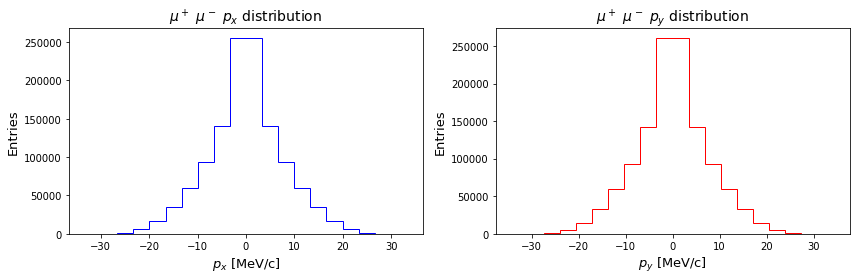

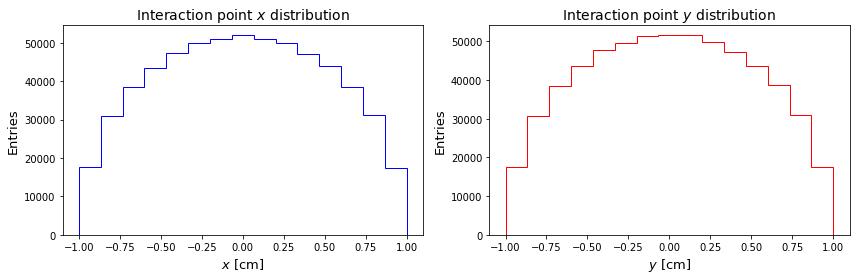

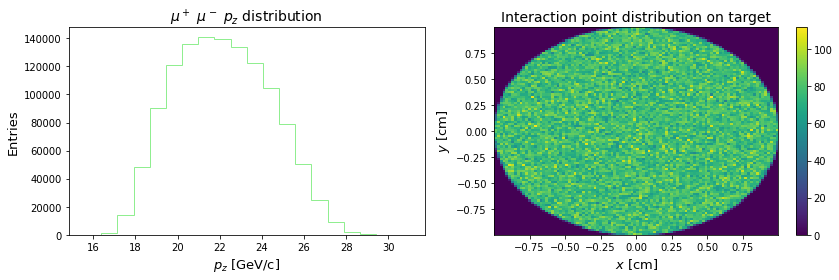

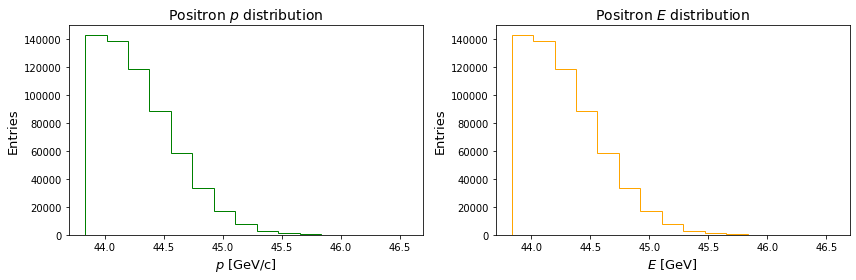

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax1.hist(pd.concat([data["px1"], data["px2"]]), bins=20, histtype="step", color="b")
ax2.hist(pd.concat([data["py1"], data["py2"]]), bins=20, histtype="step", color="r")

ax1.set_title("$\mu^+$ $\mu^-$ $p_x$ distribution", fontsize=14)
ax1.set_xlabel("$p_x$ [MeV/c]", fontsize=13)
ax1.set_ylabel("Entries", fontsize=13)
ax2.set_title("$\mu^+$ $\mu^-$ $p_y$ distribution", fontsize=14)
ax2.set_xlabel("$p_y$ [MeV/c]", fontsize=13)
ax2.set_ylabel("Entries", fontsize=13)

fig2, (ax4, ax5) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax4.hist(data["x"]*100, bins=15, histtype="step", color="b")
ax5.hist(data["y"]*100, bins=15, histtype="step", color="r")

ax4.set_title("Interaction point $x$ distribution", fontsize=14)
ax4.set_xlabel("$x$ [cm]", fontsize=13)
ax4.set_ylabel("Entries", fontsize=13)
ax5.set_title("Interaction point $y$ distribution", fontsize=14)
ax5.set_xlabel("$y$ [cm]", fontsize=13)
ax5.set_ylabel("Entries", fontsize=13)

fig3, (ax3, ax6) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax3.hist(pd.concat([data["pz1"], data["pz2"]])/1000, bins=20, histtype="step", color="LightGreen")
ax3.set_title("$\mu^+$ $\mu^-$ $p_z$ distribution", fontsize=14)
ax3.set_xlabel("$p_z$ [GeV/c]", fontsize=13)
ax3.set_ylabel("Entries", fontsize=13)

hh = ax6.hist2d(data["x"]*100, data["y"]*100, bins=100)
ax6.set_title("Interaction point distribution on target", fontsize=14)
ax6.set_xlabel("$x$ [cm]", fontsize=13)
ax6.set_ylabel("$y$ [cm]", fontsize=13)
fig.colorbar(hh[3], ax=ax6)

fig4, (ax7, ax8) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax7.hist(data["pz"]/1000, bins=15, histtype="step", color="g")
ax8.hist(data["E"]/1000, bins=15, histtype="step", color="Orange")

ax7.set_title("Positron $p$ distribution", fontsize=14)
ax7.set_xlabel("$p$ [GeV/c]", fontsize=13)
ax7.set_ylabel("Entries", fontsize=13)
ax8.set_title("Positron $E$ distribution", fontsize=14)
ax8.set_xlabel("$E$ [GeV]", fontsize=13)
ax8.set_ylabel("Entries", fontsize=13)

fig.tight_layout()
fig2.tight_layout()
fig3.tight_layout()
fig4.tight_layout()
plt.show()

Computing some useful quantities and adding them to the dataframe: magnitude of the two muon momenta $p_1$ and $p_2$, their transverse momenta $p_{t1}$ and $p_{t2}$ and their angle $\theta$ with respect to the z axis $\theta_1$ and $\theta_2$:

In [7]:
data["z"] = 0 # Adding a column for the z coordinate of the interaction point, assuming the target to be thin on the z direction
data["p1"] = np.sqrt(data["px1"]**2+data["py1"]**2+data["pz1"]**2)
data["p2"] = np.sqrt(data["px2"]**2+data["py2"]**2+data["pz2"]**2)
data["pt1"] = np.sqrt(data["px1"]**2+data["py1"]**2)
data["pt2"] = np.sqrt(data["px2"]**2+data["py2"]**2)
data["theta1"] = np.arctan(data["pt1"]/data["pz1"])
data["theta2"] = np.arctan(data["pt2"]/data["pz2"])
data

ID        px1        py1           pz1        px2        py2  \
0            0  -3.029572  -0.047757  19204.422533   3.029572   0.047757   
1            2   0.140886   0.179824  23249.900230  -0.140886  -0.179824   
2            3   2.610203 -11.938944  22107.905868  -2.610203  11.938944   
3            4   0.257288   1.866798  22770.319036  -0.257288  -1.866798   
4            7 -20.115379  -4.232671  24469.810767  20.115379   4.232671   
...        ...        ...        ...           ...        ...        ...   
609561  998449   2.782164  -0.368483  24573.814992  -2.782164   0.368483   
609562  998450  -1.080245  -0.329150  19007.443330   1.080245   0.329150   
609563  998451  -0.220189   0.204332  18008.672346   0.220189  -0.204332   
609564  998452  -0.344352  -0.830437  17841.959587   0.344352   0.830437   
609565  998454   7.429367   5.102484  23691.596201  -7.429367  -5.102484   

                 pz2         x         y            pz             E  z  \
0       25034.366621 -0.004786 -0.007443  44238.792198  44238.792201  0   
1       20661.504934  0.001313  0.005170  43911.404413  43911.404416  0   
2       22019.369509 -0.001602  0.003090  44127.277132  44127.277135  0   
3       21103.283885  0.002011 -0.005798  43873.601729  43873.601732  0   
4       20374.379433  0.003083 -0.005695  44844.200190  44844.200193  0   
...              ...       ...       ...           ...           ... ..   
609561  19562.061512 -0.005020  0.007345  44135.878359  44135.878362  0   
609562  25275.906835  0.003489  0.008994  44283.353725  44283.353728  0   
609563  26674.879685  0.007452 -0.003910  44683.560187  44683.560190  0   
609564  26925.855095 -0.003806  0.004641  44767.823801  44767.823804  0   
609565  20423.736997 -0.000007 -0.004663  44115.334814  44115.334817  0   

                  p1            p2        pt1        pt2    theta1    theta2  
0       19204.422772  25034.366804   3.029948   3.029948  0.000158  0.000121  
1       23249.900231  20661.504935   0.228442   0.228442  0.000010  0.000011  
2       22107.909246  22019.372900  12.220947  12.220947  0.000553  0.000555  
3       22770.319114  21103.283969   1.884445   1.884445  0.000083  0.000089  
4       24469.819401  20374.389802  20.555874  20.555874  0.000840  0.001009  
...              ...           ...        ...        ...       ...       ...  
609561  24573.815152  19562.061714   2.806460   2.806460  0.000114  0.000143  
609562  19007.443364  25275.906861   1.129278   1.129278  0.000059  0.000045  
609563  18008.672348  26674.879686   0.300391   0.300391  0.000017  0.000011  
609564  17841.959609  26925.855110   0.899002   0.899002  0.000050  0.000033  
609565  23691.597915  20423.738985   9.012815   9.012815  0.000380  0.000441  

[609566 rows x 18 columns]

Plotting the distribution of the new defined quantities:

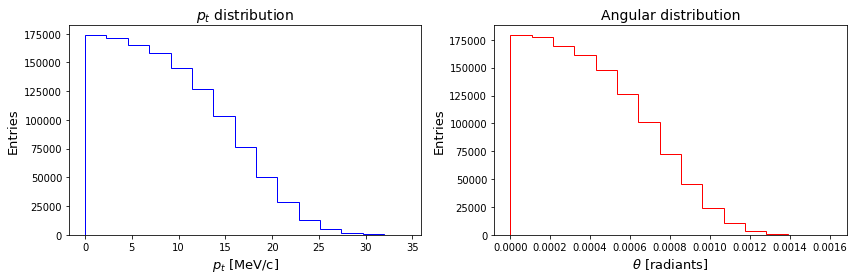

The maximum value of theta is ~0.0016028, which corresponds to 0.0005102π radiants or 0.09183 degrees.


In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax1.hist(pd.concat([data["pt1"], data["pt2"]]), bins=15, histtype="step", color="b")
ax2.hist(pd.concat([data["theta1"], data["theta2"]]), bins=15, histtype="step", color="r")
ax1.set_title("$p_t$ distribution", fontsize=14)
ax1.set_xlabel("$p_t$ [MeV/c]", fontsize=13)
ax1.set_ylabel("Entries", fontsize=13)
ax2.set_title("Angular distribution", fontsize=14)
ax2.set_xlabel("$\\theta$ [radiants]", fontsize=13)
ax2.set_ylabel("Entries", fontsize=13)
fig.tight_layout()
plt.show()

maxthetadata = np.max(pd.concat([data["theta1"], data["theta2"]]))
print("The maximum value of theta is ~%.7f, which corresponds to %.7fπ radiants or %.5f degrees." % (maxthetadata, maxthetadata/np.pi, maxthetadata*360/(2*np.pi)))

# Choice of the size of the detectors

Now we choose the position of the various components of the experiment. Since we defined the z axis to be the direction of the positron beam, we place three trackers (A1, A2, A3) to detect the positrons before hitting the target along the z axis, at positions $z_{A1}$= -3 m, $z_{A2}$= -2 m, $z_{A3}$= -1 m, recalling that the target is placed at $z_{target}$= 0 m and the beam radius is 1 cm. The following plots show the space distribution on the x-y plane of the positrons in correspondence of the three trackers.

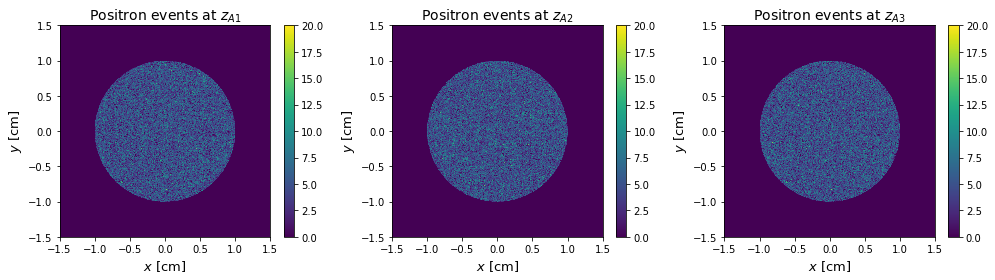

In [9]:
inipos = [data["x"], data["y"], data["z"]]

# positron eom
def spreadA(z):
    
    #t = (z+3)/data["pz"]

    X = data["x"].values
    Y = data["y"].values

    return X, Y

data["x1A"], data["y1A"] = spreadA(-3)
data["x2A"], data["y2A"] = spreadA(-2)
data["x3A"], data["y3A"] = spreadA(-1)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
hh1 = ax1.hist2d(100*data["x1A"], 100*data["y1A"], range=[[-1.5, 1.5],[-1.5, 1.5]], bins=600, vmin=0, vmax=20, cmap = 'viridis')
hh2 = ax2.hist2d(100*data["x2A"], 100*data["y2A"], range=[[-1.5, 1.5],[-1.5, 1.5]], bins=600, vmin=0, vmax=20, cmap = 'viridis')
hh3 = ax3.hist2d(100*data["x3A"], 100*data["y3A"], range=[[-1.5, 1.5],[-1.5, 1.5]], bins=600, vmin=0, vmax=20, cmap = 'viridis')

fig.colorbar(hh1[3], ax=ax1)
fig.colorbar(hh2[3], ax=ax2)
fig.colorbar(hh3[3], ax=ax3)
ax1.set_title("Positron events at $z_{A1}$", fontsize=14)
ax1.set_xlabel("$x$ [cm]", fontsize=13)
ax1.set_ylabel("$y$ [cm]", fontsize=13)
ax2.set_title("Positron events at $z_{A2}$", fontsize=14)
ax2.set_xlabel("$x$ [cm]", fontsize=13)
ax2.set_ylabel("$y$ [cm]", fontsize=13)
ax3.set_title("Positron events at $z_{A3}$", fontsize=14)
ax3.set_xlabel("$x$ [cm]", fontsize=13)
ax3.set_ylabel("$y$ [cm]", fontsize=13)

fig.tight_layout()
plt.show()

It's worth to point out that these positrons do not have transverse momentum components (i.e. they have only z component), therefore we don't see any significant change in the distribution of the particles.
Since the beam has a radius of 1 cm, we can safely affirm that the detector has an acceptance of 100% if we choose it to be 3x3 cm$^2$ large.

After hitting the target, in order to have a smaller spread of the muons, three trackers (B1, B2, B3) are placed right after it, at $z_{B1}$ = 0.5 m, $z_{B2}$ = 1.5 m and $\quad$ $z_{B3}$ = 2.5 m on the z axis.

In [10]:
direction1 = [data["px1"], data["py1"], data["pz1"]]
direction2 = [data["px2"], data["py2"], data["pz2"]]

#x1 = x + (z/pz1) * px1
#y1 = y + (z/pz1) * py1
#z1 = 0 + t  * pz1

# muon eom after target before magnet
def spreadB(z):
    
    t1 = z/data["pz1"]
    t2 = z/data["pz2"]

    X1 = (data["x"]+t1*data["px1"]).values
    Y1 = (data["y"]+t1*data["py1"]).values
    X2 = (data["x"]+t2*data["px2"]).values
    Y2 = (data["y"]+t2*data["py2"]).values

    return X1, Y1, X2, Y2

data["x1B1"], data["y1B1"], data["x1B2"], data["y1B2"] = spreadB(0.5)
data["x2B1"], data["y2B1"], data["x2B2"], data["y2B2"] = spreadB(1.5)
data["x3B1"], data["y3B1"], data["x3B2"], data["y3B2"] = spreadB(2.5)

X = np.concatenate([data["x3B1"],data["x3B2"]])
Y = np.concatenate([data["y3B1"],data["y3B2"]])
maxr3B = np.max(np.sqrt(X**2+Y**2))

print("The muon furthest from the beam axis at tracker B3 is %.4f cm off the beam axis." % (100*maxr3B))

The muon furthest from the beam axis at tracker B3 is 1.3443 cm off the beam axis.


We can see that even in the furthest B detector the muon distribution is limited inside the dimensions of the trackers used in the previous case.
Therefore as for A trackers if we consider 3x3 cm$^2$ large trackers right after the target, we can contain all the events inside them. The following plots show the space distribution on the x-y plane of the positrons in correspondence of the three trackers.

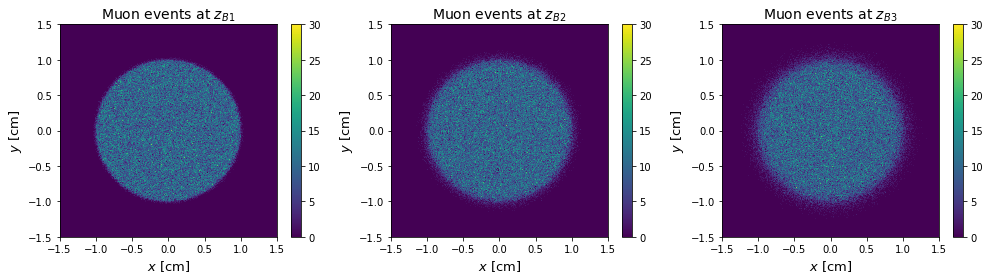

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
hh1 = ax1.hist2d(100*pd.concat([data["x1B1"], data["x1B2"]]), 100*pd.concat([data["y1B1"], data["y1B2"]]), range=[[-1.5, 1.5],[-1.5, 1.5]], bins=600, vmin=0, vmax=30, cmap = 'viridis')
hh2 = ax2.hist2d(100*pd.concat([data["x2B1"], data["x2B2"]]), 100*pd.concat([data["y2B1"], data["y2B2"]]), range=[[-1.5, 1.5],[-1.5, 1.5]], bins=600, vmin=0, vmax=30, cmap = 'viridis')
hh3 = ax3.hist2d(100*pd.concat([data["x3B1"], data["x3B2"]]), 100*pd.concat([data["y3B1"], data["y3B2"]]), range=[[-1.5, 1.5],[-1.5, 1.5]], bins=600, vmin=0, vmax=30, cmap = 'viridis')

fig.colorbar(hh1[3], ax=ax1)
fig.colorbar(hh2[3], ax=ax2)
fig.colorbar(hh3[3], ax=ax3)
ax1.set_title("Muon events at $z_{B1}$", fontsize=14)
ax1.set_xlabel("$x$ [cm]", fontsize=13)
ax1.set_ylabel("$y$ [cm]", fontsize=13)
ax2.set_title("Muon events at $z_{B2}$", fontsize=14)
ax2.set_xlabel("$x$ [cm]", fontsize=13)
ax2.set_ylabel("$y$ [cm]", fontsize=13)
ax3.set_title("Muon events at $z_{B3}$", fontsize=14)
ax3.set_xlabel("$x$ [cm]", fontsize=13)
ax3.set_ylabel("$y$ [cm]", fontsize=13)

fig.tight_layout()
plt.show()

We can observe that all the events are contained in the 3x3 cm$^2$ tracker.

Now we study the behaviour of the muons under the presence of the magnetic field. The magnet is 2 m long, placed between $z_{in}$ = 3 m and $z_{out}$ = 5 m and generates a field of 1.7 T. The magnetic field is assumed to be uniform and directed along the negative direction of the y axis (see image below).

Using the given information, we define two functions to calculate the deflection of positive muons and negative muons under the effect of the magnetic field:

In [12]:
def xBoutpos(pxin, pyin, pzin):  # function that calculates the x position where the muon gets out of the magnet given the initial momentum
    
    pinev = np.sqrt((pxin**2)+(pzin**2)) #MeV/c
    pin = pinev*10**6*q/c #kgm/s
    gamma = 1/np.sqrt(1-(np.sqrt(pxin**2+pyin**2+pzin**2)/np.sqrt(mmu**2+pxin**2+pyin**2+pzin**2)))
    r = pin/(q*B) # Larmor radius
    phi = np.arctan(pxin/pzin) # Angle off the z axis projected on the xz-plane, orthogonal to the y axis
    rcenter = [-r*np.sin(phi), r*np.cos(phi)] # coordinates of center of Larmor circle (z,x)
    xout = rcenter[1] - np.sqrt(r**2 - (2-rcenter[0])**2) # maximum y coordinate shift when exiting magnet
    
    m = (rcenter[0]-2)/(xout-rcenter[1]) # Angular coefficient of line having outgoing muon direction
    xzanglepost = np.arctan(m) # Angle on xz plane wrt z axis
    
    # Calculating x, z components of outgoing momentum
    pxpost = pinev*np.sin(xzanglepost)
    pzpost = pinev*np.cos(xzanglepost)
    
    return xout, pxpost, pzpost

def xBoutneg(pxin, pyin, pzin):  # function that calculates the x position where the muon gets out of the magnet given the initial momentum
    
    pinev = np.sqrt((pxin**2)+(pzin**2))
    pin = pinev*10**6*q/c
    gamma = 1/np.sqrt(1-(np.sqrt(pxin**2+pyin**2+pzin**2)/np.sqrt(mmu**2+pxin**2+pyin**2+pzin**2)))
    r = pin/(q*B) # Larmor radius
    phi = np.arctan(pxin/pzin) # Angle off the z axis projected on the xz-plane, orthogonal to the y axis
    rcenter = [-r*np.sin(phi), -r*np.cos(phi)] # coordinates of center of Larmor circle (z,x)
    xout = rcenter[1] + np.sqrt(r**2 - (2-rcenter[0])**2) # maximum y coordinate shift when exiting magnet
    
    m = (rcenter[0]-2)/(xout-rcenter[1]) # Angular coefficient of line having outgoing muon direction
    xzanglepost = np.arctan(m) # Angle on xz plane wrt z axis
    
    # Calculating x, z components of outgoing momentum
    pxpost = pinev*np.sin(xzanglepost)
    pzpost = pinev*np.cos(xzanglepost)
    
    return xout, pxpost, pzpost

The coordinates and the momenta of the muons at $z_{in}$ and $z_{out}$ are calculated using the functions defined above.

In [13]:
data["x1pre"], data["y1pre"], data["x2pre"], data["y2pre"] = spreadB(3)

x1shift, data["px1post"], data["pz1post"] = xBoutpos(data["px1"], data["py1"], data["pz1"])
x2shift, data["px2post"], data["pz2post"] = xBoutneg(data["px2"], data["py2"], data["pz2"])

data["x1post"] = data["x1pre"] + x1shift
data["y1post"] = data["y"]+(5/data["pz1"])*data["py1"]
data["z1post"] = 5

data["x2post"] = data["x2pre"] + x2shift
data["y2post"] = data["y"]+(5/data["pz2"])*data["py2"]
data["z2post"] = 5


print("x extremes of events outgoing from the magnet:\n xmin = %.2f cm, xmax = %.2f cm" % (np.min(pd.concat([data["x1post"], data["x2post"]]))*100, np.max(pd.concat([data["x1post"], data["x2post"]]))*100))
print("y extremes of events outgoing from the magnet:\n ymin = %.2f cm, ymax = %.2f cm" % (np.min(pd.concat([data["y1post"], data["y2post"]]))*100, np.max(pd.concat([data["y1post"], data["y2post"]]))*100))

x extremes of events outgoing from the magnet:
 xmin = -7.17 cm, xmax = 7.26 cm
y extremes of events outgoing from the magnet:
 ymin = -1.63 cm, ymax = 1.60 cm


Given the results above, its safe to say that all the particles will cross the magnetic field as intended if we consider a magnetic field confined in a box of x,y,z = 20x5x200 cm$^3$.

Once obtained the properties of the muons right after the magnet, it's possible to study the propagation of the muons after the magnet. After the magnet two distinct deflected beams are obtained, therefore we place three trackers along each beam: CP1, CP2, CP3 along the positive charged beam and CN1, CN2, CN3 along the negative charged beam. Both C1 trackers are placed at $z_{C1}$ = 6.5 m, C2 at $z_{C2}$ = 7.5 m and C3 at $z_{C3}$ = 8.5 m. The trackers were positioned far from the magnet compared to the other distances between the trackers in order to have two distinct beams. It also has to be underlined that considering the deflection of the two beams, the C trackers are not located along the z axis (i.e. the center of each tracker has an x coordinate different from zero).

In [14]:
# muons eom after the magnet
def spreadC(z):
    
    l1 = (z-5)/data["pz1post"]
    l2 = (z-5)/data["pz2post"]

    X1 = (data["x1post"]+l1*data["px1post"]).values
    Y1 = (data["y1post"]+l1*data["py1"]).values
    X2 = (data["x2post"]+l2*data["px2post"]).values
    Y2 = (data["y2post"]+l2*data["py2"]).values

    return X1, Y1, X2, Y2

data["x1C1"], data["y1C1"], data["x1C2"], data["y1C2"] = spreadC(6.5)
data["x2C1"], data["y2C1"], data["x2C2"], data["y2C2"] = spreadC(7.5)
data["x3C1"], data["y3C1"], data["x3C2"], data["y3C2"] = spreadC(8.5)

The plots below display the distribution of the muons at $z_{C1}$, $z_{C2}$, $z_{C3}$:

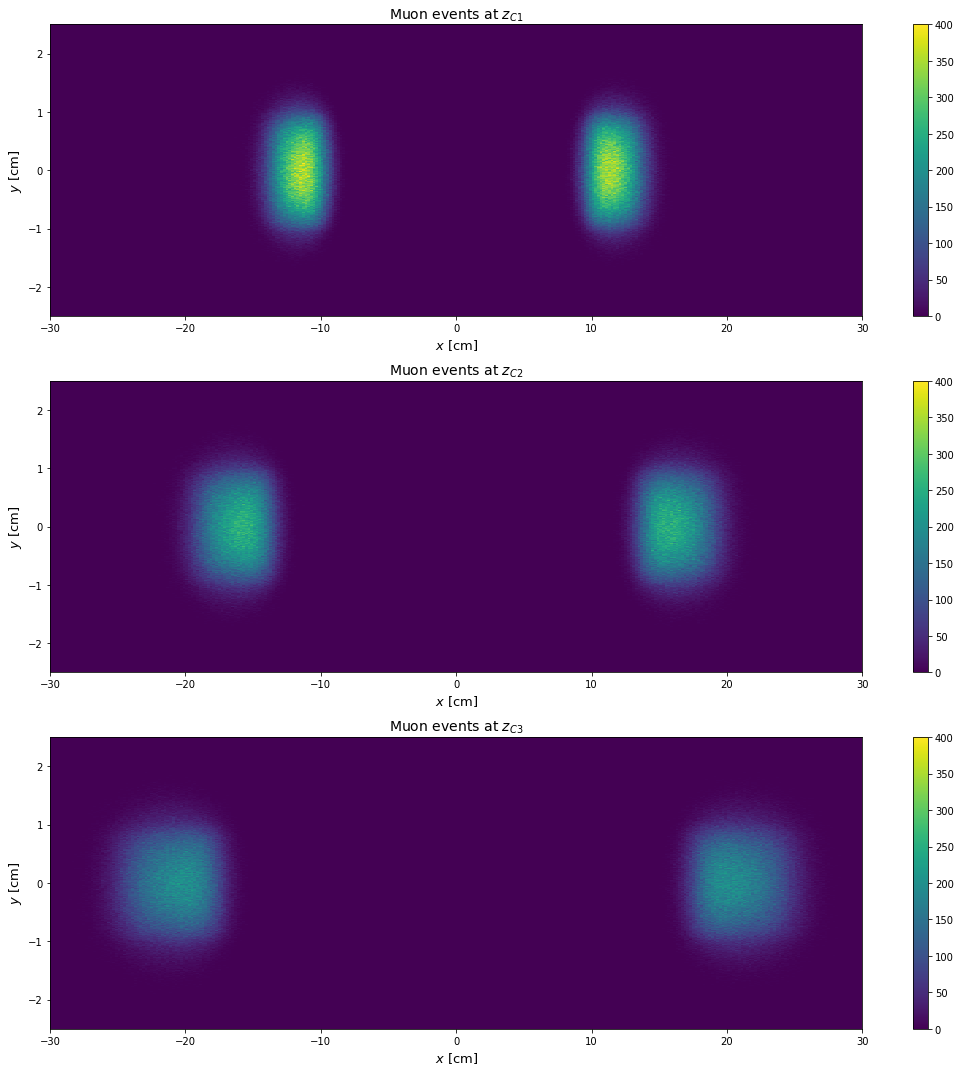

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(15,15))
hh1 = ax1.hist2d(100*pd.concat([data["x1C1"], data["x1C2"]]), 100*pd.concat([data["y1C1"], data["y1C2"]]), range=[[-30, 30],[-2.5, 2.5]], bins=300, vmin=0, vmax=400, cmap = 'viridis')
hh2 = ax2.hist2d(100*pd.concat([data["x2C1"], data["x2C2"]]), 100*pd.concat([data["y2C1"], data["y2C2"]]), range=[[-30, 30],[-2.5, 2.5]], bins=300, vmin=0, vmax=400, cmap = 'viridis')
hh3 = ax3.hist2d(100*pd.concat([data["x3C1"], data["x3C2"]]), 100*pd.concat([data["y3C1"], data["y3C2"]]), range=[[-30, 30],[-2.5, 2.5]], bins=300, vmin=0, vmax=400, cmap = 'viridis')

fig.colorbar(hh1[3], ax=ax1)
fig.colorbar(hh2[3], ax=ax2)
fig.colorbar(hh3[3], ax=ax3)
ax1.set_title("Muon events at $z_{C1}$", fontsize=14)
ax1.set_xlabel("$x$ [cm]", fontsize=13)
ax1.set_ylabel("$y$ [cm]", fontsize=13)
ax2.set_title("Muon events at $z_{C2}$", fontsize=14)
ax2.set_xlabel("$x$ [cm]", fontsize=13)
ax2.set_ylabel("$y$ [cm]", fontsize=13)
ax3.set_title("Muon events at $z_{C3}$", fontsize=14)
ax3.set_xlabel("$x$ [cm]", fontsize=13)
ax3.set_ylabel("$y$ [cm]", fontsize=13)

fig.tight_layout()
plt.show()

Focusing on each beam section individually the following plots are obtained:

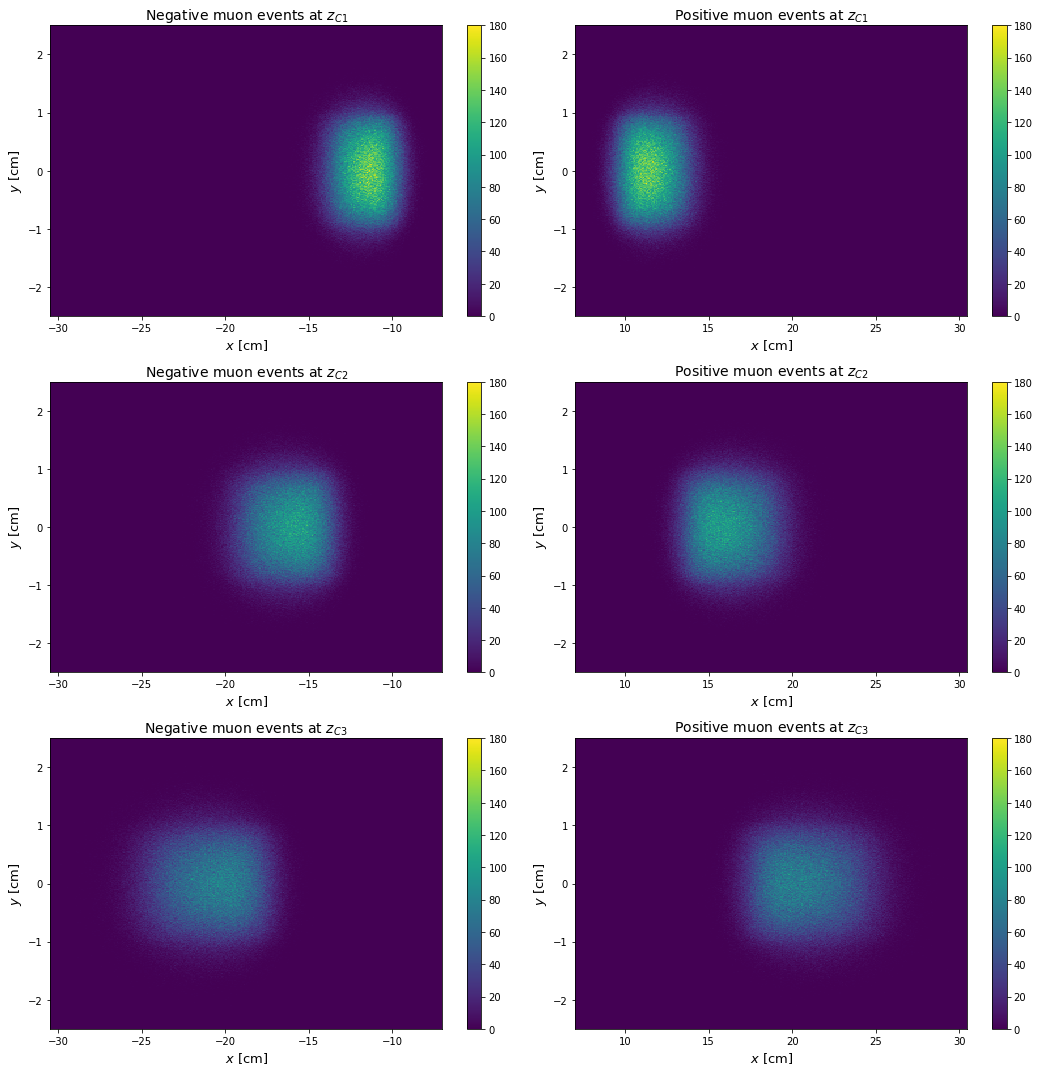

In [16]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
hh2 = ax2.hist2d(100*data["x1C1"], 100*data["y1C1"], bins=300, vmin=0, vmax=180, range=[[7,30.5],[-2.5,2.5]], cmap = 'viridis')
hh1 = ax1.hist2d(100*data["x1C2"], 100*data["y1C2"], bins=300, vmin=0, vmax=180, range=[[-30.5,-7],[-2.5,2.5]], cmap = 'viridis')
hh4 = ax4.hist2d(100*data["x2C1"], 100*data["y2C1"], bins=300, vmin=0, vmax=180, range=[[7,30.5],[-2.5,2.5]], cmap = 'viridis')
hh3 = ax3.hist2d(100*data["x2C2"], 100*data["y2C2"], bins=300, vmin=0, vmax=180, range=[[-30.5,-7],[-2.5,2.5]], cmap = 'viridis')
hh6 = ax6.hist2d(100*data["x3C1"], 100*data["y3C1"], bins=300, vmin=0, vmax=180, range=[[7,30.5],[-2.5,2.5]], cmap = 'viridis')
hh5 = ax5.hist2d(100*data["x3C2"], 100*data["y3C2"], bins=300, vmin=0, vmax=180, range=[[-30.5,-7],[-2.5,2.5]], cmap = 'viridis')

fig.colorbar(hh1[3], ax=ax1)
fig.colorbar(hh2[3], ax=ax2)
fig.colorbar(hh3[3], ax=ax3)
fig.colorbar(hh4[3], ax=ax4)
fig.colorbar(hh5[3], ax=ax5)
fig.colorbar(hh6[3], ax=ax6)
ax1.set_title("Negative muon events at $z_{C1}$", fontsize=14)
ax1.set_xlabel("$x$ [cm]", fontsize=13)
ax1.set_ylabel("$y$ [cm]", fontsize=13)
ax2.set_title("Positive muon events at $z_{C1}$", fontsize=14)
ax2.set_xlabel("$x$ [cm]", fontsize=13)
ax2.set_ylabel("$y$ [cm]", fontsize=13)
ax3.set_title("Negative muon events at $z_{C2}$", fontsize=14)
ax3.set_xlabel("$x$ [cm]", fontsize=13)
ax3.set_ylabel("$y$ [cm]", fontsize=13)
ax4.set_title("Positive muon events at $z_{C2}$", fontsize=14)
ax4.set_xlabel("$x$ [cm]", fontsize=13)
ax4.set_ylabel("$y$ [cm]", fontsize=13)
ax5.set_title("Negative muon events at $z_{C3}$", fontsize=14)
ax5.set_xlabel("$x$ [cm]", fontsize=13)
ax5.set_ylabel("$y$ [cm]", fontsize=13)
ax6.set_title("Positive muon events at $z_{C3}$", fontsize=14)
ax6.set_xlabel("$x$ [cm]", fontsize=13)
ax6.set_ylabel("$y$ [cm]", fontsize=13)

fig.tight_layout()
plt.show()

In [17]:
#print min and max events
print("CP1 Tracker extreme events:\n xmin = %.2f cm, xmax = %.2f cm, xcenter = %.2f cm\n ymin = %.2f cm, ymax = %.2f cm, ycenter = %.2f cm" % (np.min(100*data["x1C1"]), np.max(100*data["x1C1"]), (np.max(100*data["x1C1"])+np.min(100*data["x1C1"]))/2, np.min(100*data["y1C1"]), np.max(100*data["y1C1"]), (np.max(100*data["y1C1"])+np.min(100*data["y1C1"]))/2))
print("CN1 Tracker extreme events:\n xmin = %.2f cm, xmax = %.2f cm, xcenter = %.2f cm\n ymin = %.2f cm, ymax = %.2f cm, ycenter = %.2f cm" % (np.min(100*data["x1C2"]), np.max(100*data["x1C2"]), (np.max(100*data["x1C2"])+np.min(100*data["x1C2"]))/2, np.min(100*data["y1C2"]), np.max(100*data["y1C2"]), (np.max(100*data["y1C2"])+np.min(100*data["y1C2"]))/2))
print("CP2 Tracker extreme events:\n xmin = %.2f cm, xmax = %.2f cm, xcenter = %.2f cm\n ymin = %.2f cm, ymax = %.2f cm, ycenter = %.2f cm" % (np.min(100*data["x2C1"]), np.max(100*data["x2C1"]), (np.max(100*data["x2C1"])+np.min(100*data["x2C1"]))/2, np.min(100*data["y2C1"]), np.max(100*data["y2C1"]), (np.max(100*data["y2C1"])+np.min(100*data["y2C1"]))/2))
print("CN2 Tracker extreme events:\n xmin = %.2f cm, xmax = %.2f cm, xcenter = %.2f cm\n ymin = %.2f cm, ymax = %.2f cm, ycenter = %.2f cm" % (np.min(100*data["x2C2"]), np.max(100*data["x2C2"]), (np.max(100*data["x2C2"])+np.min(100*data["x2C2"]))/2, np.min(100*data["y2C2"]), np.max(100*data["y2C2"]), (np.max(100*data["y2C2"])+np.min(100*data["y2C2"]))/2))
print("CP3 Tracker extreme events:\n xmin = %.2f cm, xmax = %.2f cm, xcenter = %.2f cm\n ymin = %.2f cm, ymax = %.2f cm, ycenter = %.2f cm" % (np.min(100*data["x3C1"]), np.max(100*data["x3C1"]), (np.max(100*data["x3C1"])+np.min(100*data["x3C1"]))/2, np.min(100*data["y3C1"]), np.max(100*data["y3C1"]), (np.max(100*data["y3C1"])+np.min(100*data["y3C1"]))/2))
print("CN3 Tracker extreme events:\n xmin = %.2f cm, xmax = %.2f cm, xcenter = %.2f cm\n ymin = %.2f cm, ymax = %.2f cm, ycenter = %.2f cm" % (np.min(100*data["x3C2"]), np.max(100*data["x3C2"]), (np.max(100*data["x3C2"])+np.min(100*data["x3C2"]))/2, np.min(100*data["y3C2"]), np.max(100*data["y3C2"]), (np.max(100*data["y3C2"])+np.min(100*data["y3C2"]))/2))

CP1 Tracker extreme events:
 xmin = 7.67 cm, xmax = 16.65 cm, xcenter = 12.16 cm
 ymin = -1.82 cm, ymax = 1.81 cm, ycenter = -0.00 cm
CN1 Tracker extreme events:
 xmin = -16.77 cm, xmax = -7.75 cm, xcenter = -12.26 cm
 ymin = -1.83 cm, ymax = 1.77 cm, ycenter = -0.03 cm
CP2 Tracker extreme events:
 xmin = 11.12 cm, xmax = 22.98 cm, xcenter = 17.05 cm
 ymin = -1.95 cm, ymax = 1.95 cm, ycenter = -0.00 cm
CN2 Tracker extreme events:
 xmin = -23.31 cm, xmax = -11.19 cm, xcenter = -17.25 cm
 ymin = -1.96 cm, ymax = 1.89 cm, ycenter = -0.04 cm
CP3 Tracker extreme events:
 xmin = 14.41 cm, xmax = 29.39 cm, xcenter = 21.90 cm
 ymin = -2.09 cm, ymax = 2.08 cm, ycenter = -0.00 cm
CN3 Tracker extreme events:
 xmin = -29.85 cm, xmax = -14.63 cm, xcenter = -22.24 cm
 ymin = -2.09 cm, ymax = 2.01 cm, ycenter = -0.04 cm


We can observe that the muon distribution spreads out faster after the magnet compared to before.
In order to contain all events in the tracker, we impose the tracker dimensions $x$,$y$ and positions along the $x$ axis to be the following:<br>
- 13x5 cm$^2$ for C1 Trackers, at $x_{C1}^{\mu±}$ = ±12.5 cm;
- 17x5 cm$^2$ for C2 Trackers, at $x_{C2}^{\mu±}$ = ±17 cm;
- 19x7 cm$^2$ for C3 Trackers, at $x_{C3}^{\mu±}$ = ±22 cm.

Therefore the experiment will look like the following image:

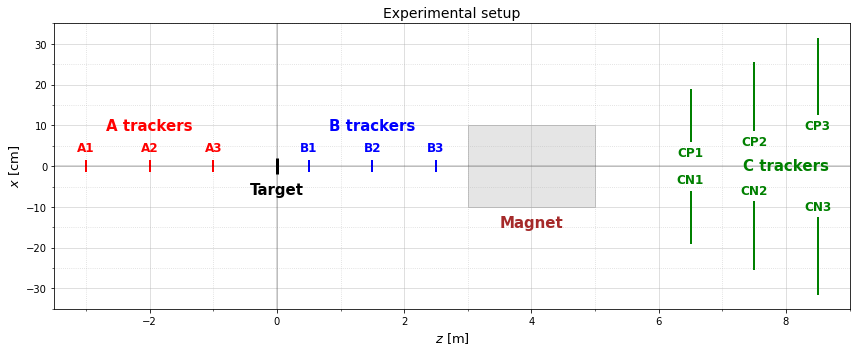

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

trackerA = [[(-3, -1.5), (-3, 1.5)], [(-2, -1.5), (-2, 1.5)], [(-1, -1.5), (-1, 1.5)]]
trackerB = [[(0.5, -1.5), (0.5, 1.5)], [(1.5, -1.5), (1.5, 1.5)], [(2.5, -1.5), (2.5, 1.5)]]
trackerC1 = [[(6.5, 6), (6.5, 19)], [(7.5, 8.5), (7.5, 25.5)], [(8.5, 12.5), (8.5, 31.5)]]
trackerC2 = [[(6.5, -6), (6.5, -19)], [(7.5, -8.5), (7.5, -25.5)], [(8.5, -12.5), (8.5, -31.5)]]
target = [[(0, -2), (0, 2)]]
cls = ["r", "r", "r", "b", "b", "b", "g", "g", "g", "g", "g", "g"]

lc = mc.LineCollection(trackerA+trackerB+trackerC1+trackerC2, colors=cls, linewidths=2)
lct = mc.LineCollection(target, colors="k", linewidths=3)
ax.add_collection(lc)
ax.add_collection(lct)

ax.add_patch(Rectangle((3,-10), 2, 20, edgecolor = "k", facecolor = "gray", fill=True, alpha=0.2))

ax.set_title("Experimental setup", fontsize=14)
ax.set_xlim(-3.5, 9)
ax.set_ylim(-35, 35)

xmajor_ticks = np.arange(-2, 10, 2)
xminor_ticks = np.arange(-3, 10, 1)
ax.set_xticks(xmajor_ticks)
ax.set_xticks(xminor_ticks, minor=True)
ymajor_ticks = np.arange(-30, 31, 10)
yminor_ticks = np.arange(-35, 36, 5)
ax.set_yticks(ymajor_ticks)
ax.set_yticks(yminor_ticks, minor=True)

ax.set_xlabel("$z$ [m]", fontsize=13)
ax.set_ylabel("$x$ [cm]", fontsize=13)
ax.axhline(0, color="k", alpha=0.2)
ax.axvline(0, color="k", alpha=0.2)

ax.text(-2, 10, "A trackers", ha="center", va="center", weight="bold", color="r", fontsize=15)
ax.text(-3, 3, "A1", ha="center", va="bottom", weight="bold", color="r", fontsize=12)
ax.text(-2, 3, "A2", ha="center", va="bottom", weight="bold", color="r", fontsize=12)
ax.text(-1, 3, "A3", ha="center", va="bottom", weight="bold", color="r", fontsize=12)
ax.text(0, -4, "Target", ha="center", va="top", weight="bold", color="k", fontsize=15)
ax.text(1.5, 10, "B trackers", ha="center", va="center", weight="bold", color="b", fontsize=15)
ax.text(0.5, 3, "B1", ha="center", va="bottom", weight="bold", color="b", fontsize=12)
ax.text(1.5, 3, "B2", ha="center", va="bottom", weight="bold", color="b", fontsize=12)
ax.text(2.5, 3, "B3", ha="center", va="bottom", weight="bold", color="b", fontsize=12)
ax.text(4, -12, "Magnet", ha="center", va="top", weight="bold", color="Brown", fontsize=15)
ax.text(8, 0, "C trackers", ha="center", va="center", weight="bold", color="g", fontsize=15)
ax.text(6.5, 5, "CP1", ha="center", va="top", weight="bold", color="g", fontsize=12)
ax.text(7.5, 7.5, "CP2", ha="center", va="top", weight="bold", color="g", fontsize=12)
ax.text(8.5, 11.5, "CP3", ha="center", va="top", weight="bold", color="g", fontsize=12)
ax.text(6.5, -5, "CN1", ha="center", va="bottom", weight="bold", color="g", fontsize=12)
ax.text(7.5, -7.5, "CN2", ha="center", va="bottom", weight="bold", color="g", fontsize=12)
ax.text(8.5, -11.5, "CN3", ha="center", va="bottom", weight="bold", color="g", fontsize=12)

fig.tight_layout()
ax.grid(which="major", alpha=0.5)
ax.grid(which="minor", alpha=0.5, linestyle=":")
plt.show()

At this point the dimension of each silicon pixel must be chosen for each tracker. 
For B trackers, a rough estimation of the portion of events having both muons hitting the same pixel in each tracker is computed, by calculating the percentage of events that are made by muons displaced on the x-y plane by a distance smaller than a pixel size.

In [19]:
def check_thres(x1, x2, y1, y2, thresh): # for B trackers
    tc = str(x1.name[2]) + str(x1.name[1])
    pc = (np.sqrt((x1-x2)**2 + (y2-y1)**2) < thresh).sum()/len(x1)*100
    print("Percentage of muons displaced below threshold at tracker %s = %d μm: %.2f%%" % (tc, np.around(thresh*10**6), pc))

resA = 50*10**(-6)  
resB = 50*10**(-6)
resC = 200*10**(-6)
    
check_thres(data["x1B1"], data["x1B2"], data["y1B1"], data["y1B2"], resB)
check_thres(data["x2B1"], data["x2B2"], data["y2B1"], data["y2B2"], resB)
check_thres(data["x3B1"], data["x3B2"], data["y3B1"], data["y3B2"], resB)

Percentage of muons displaced below threshold at tracker B1 = 50 μm: 6.76%
Percentage of muons displaced below threshold at tracker B2 = 50 μm: 2.26%
Percentage of muons displaced below threshold at tracker B3 = 50 μm: 1.35%


Considering high particle density, it is appropriate to use silicon pixels having the smallest available size in B trackers, which is 50x50 μm$^2$. To have a precise reconstruction of the interaction point on the target, A trackers resolutions should also be as small as possible.
As for C trackers, taking into account that the particle distribution reaching them are more spread out in space, therefore the beam has a lower particle density, and since the dimension of the trackers themselves are larger, it's more convenient to adopt 200x200 μm$^2$ pixels.

The target is assumed to be thin and centered at $x$, $y$, $z$ = (0, 0, 0).

# Interaction with the detectors

Now a discretized dataset is generated using the hits left by the particles crossing each detector, taking into account that the events are properly smeared due to the resolution of the detectors.

In [20]:
def pixel(x, resolution, center=0):
    # Transforms the exact coordinates into the center position of the hit pixel, discretization
    return np.around(np.floor(x/resolution)*resolution+0.5*resolution-center, 6)

In [21]:
# Defining a new dataframe to store the discretized data (position in meters)
datadet = data.loc[:,["ID", "x1A", "y1A", "x2A", "y2A", "x3A", "y3A", "x1B1", "y1B1", "x1B2", "y1B2", "x2B1", "y2B1", "x2B2", "y2B2", "x3B1", "y3B1", "x3B2", "y3B2", "x1C1", "y1C1", "x1C2", "y1C2", "x2C1", "y2C1", "x2C2", "y2C2", "x3C1", "y3C1", "x3C2", "y3C2"]].copy()
datadet["count"] = 1

# A1 tracker
datadet["x1A"] = pixel(datadet["x1A"], resA)
datadet["y1A"] = pixel(datadet["y1A"], resA)

# A2 tracker
datadet["x2A"] = pixel(datadet["x2A"], resA)
datadet["y2A"] = pixel(datadet["y2A"], resA)

# A3 tracker
datadet["x3A"] = pixel(datadet["x3A"], resA)
datadet["y3A"] = pixel(datadet["y3A"], resA)

# B1 tracker
datadet["x1B1"] = pixel(datadet["x1B1"], resB)
datadet["y1B1"] = pixel(datadet["y1B1"], resB)
datadet["x1B2"] = pixel(datadet["x1B2"], resB)
datadet["y1B2"] = pixel(datadet["y1B2"], resB)

# B2 tracker
datadet["x2B1"] = pixel(datadet["x2B1"], resB)
datadet["y2B1"] = pixel(datadet["y2B1"], resB)
datadet["x2B2"] = pixel(datadet["x2B2"], resB)
datadet["y2B2"] = pixel(datadet["y2B2"], resB)

# B3 tracker
datadet["x3B1"] = pixel(datadet["x3B1"], resB)
datadet["y3B1"] = pixel(datadet["y3B1"], resB)
datadet["x3B2"] = pixel(datadet["x3B2"], resB)
datadet["y3B2"] = pixel(datadet["y3B2"], resB)

# C1 trackers
datadet["x1C1"] = pixel(datadet["x1C1"], resC, 0.125)
datadet["y1C1"] = pixel(datadet["y1C1"], resC)
datadet["x1C2"] = pixel(datadet["x1C2"], resC, -0.125)
datadet["y1C2"] = pixel(datadet["y1C2"], resC)

# C2 trackers
datadet["x2C1"] = pixel(datadet["x2C1"], resC, 0.170)
datadet["y2C1"] = pixel(datadet["y2C1"], resC)
datadet["x2C2"] = pixel(datadet["x2C2"], resC, -0.170)
datadet["y2C2"] = pixel(datadet["y2C2"], resC)

# C3 trackers
datadet["x3C1"] = pixel(datadet["x3C1"], resC, 0.220)
datadet["y3C1"] = pixel(datadet["y3C1"], resC)
datadet["x3C2"] = pixel(datadet["x3C2"], resC, -0.220)
datadet["y3C2"] = pixel(datadet["y3C2"], resC)

datadet

ID       x1A       y1A       x2A       y2A       x3A       y3A  \
0            0 -0.004775 -0.007425 -0.004775 -0.007425 -0.004775 -0.007425   
1            2  0.001325  0.005175  0.001325  0.005175  0.001325  0.005175   
2            3 -0.001625  0.003075 -0.001625  0.003075 -0.001625  0.003075   
3            4  0.002025 -0.005775  0.002025 -0.005775  0.002025 -0.005775   
4            7  0.003075 -0.005675  0.003075 -0.005675  0.003075 -0.005675   
...        ...       ...       ...       ...       ...       ...       ...   
609561  998449 -0.005025  0.007325 -0.005025  0.007325 -0.005025  0.007325   
609562  998450  0.003475  0.008975  0.003475  0.008975  0.003475  0.008975   
609563  998451  0.007475 -0.003925  0.007475 -0.003925  0.007475 -0.003925   
609564  998452 -0.003825  0.004625 -0.003825  0.004625 -0.003825  0.004625   
609565  998454 -0.000025 -0.004675 -0.000025 -0.004675 -0.000025 -0.004675   

            x1B1      y1B1      x1B2  ...    y1C2    x2C1    y2C1    x2C2  \
0      -0.004875 -0.007425 -0.004725  ... -0.0075  0.0101 -0.0075  0.0225   
1       0.001325  0.005175  0.001325  ...  0.0051 -0.0151  0.0053 -0.0015   
2      -0.001525  0.002825 -0.001675  ...  0.0067 -0.0091 -0.0009  0.0065   
3       0.002025 -0.005775  0.002025  ... -0.0063 -0.0111 -0.0051  0.0029   
4       0.002675 -0.005775  0.003575  ... -0.0043 -0.0271 -0.0069 -0.0037   
...          ...       ...       ...  ...     ...     ...     ...     ...   
609561 -0.004975  0.007325 -0.005075  ...  0.0075 -0.0289  0.0073 -0.0173   
609562  0.003475  0.008975  0.003525  ...  0.0091  0.0209  0.0089  0.0321   
609563  0.007425 -0.003925  0.007475  ... -0.0039  0.0357 -0.0039  0.0437   
609564 -0.003825  0.004625 -0.003825  ...  0.0049  0.0263  0.0043  0.0335   
609565  0.000125 -0.004575 -0.000175  ... -0.0063 -0.0169 -0.0031 -0.0043   

          y2C2    x3C1    y3C1    x3C2    y3C2  count  
0      -0.0075  0.0131 -0.0075  0.0315 -0.0075      1  
1       0.0051 -0.0211  0.0053 -0.0009  0.0051      1  
2       0.0071 -0.0129 -0.0015  0.0101  0.0077      1  
3      -0.0065 -0.0163 -0.0051  0.0045 -0.0065      1  
4      -0.0041 -0.0363 -0.0071 -0.0047 -0.0039      1  
...        ...     ...     ...     ...     ...    ...  
609561  0.0075 -0.0373  0.0073 -0.0195  0.0075      1  
609562  0.0091  0.0247  0.0089  0.0417  0.0091      1  
609563 -0.0039  0.0425 -0.0039  0.0553 -0.0039      1  
609564  0.0049  0.0335  0.0043  0.0457  0.0049      1  
609565 -0.0065 -0.0235 -0.0029 -0.0039 -0.0067      1  

[609566 rows x 32 columns]

In the following plots the number of hits for each pixel in each tracker is shown.

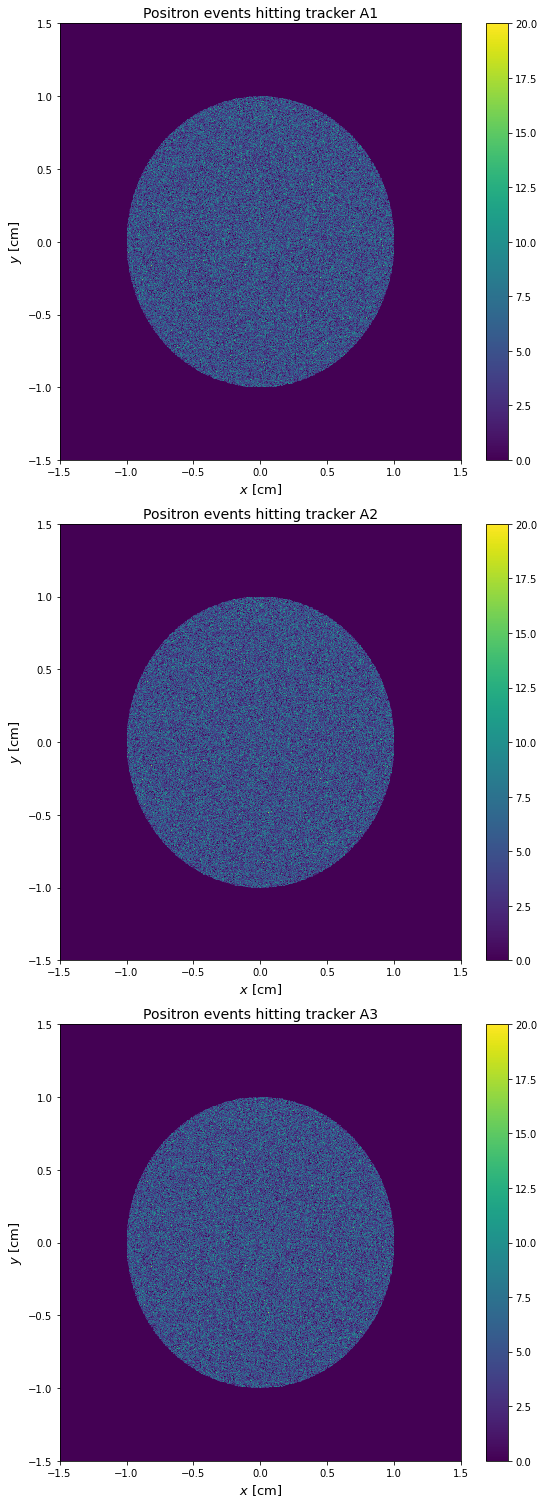

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(8,21))
hh1 = ax1.hist2d(100*datadet["x1A"], 100*datadet["y1A"], range=[[-1.5, 1.5],[-1.5, 1.5]], bins=600, vmin=0, vmax=20, cmap = 'viridis')
hh2 = ax2.hist2d(100*datadet["x2A"], 100*datadet["y2A"], range=[[-1.5, 1.5],[-1.5, 1.5]], bins=600, vmin=0, vmax=20, cmap = 'viridis')
hh3 = ax3.hist2d(100*datadet["x3A"], 100*datadet["y3A"], range=[[-1.5, 1.5],[-1.5, 1.5]], bins=600, vmin=0, vmax=20, cmap = 'viridis')

fig.colorbar(hh1[3], ax=ax1)
fig.colorbar(hh2[3], ax=ax2)
fig.colorbar(hh3[3], ax=ax3)
ax1.set_title("Positron events hitting tracker A1",fontsize = 14)
ax1.set_xlabel("$x$ [cm]",fontsize = 13)
ax1.set_ylabel("$y$ [cm]",fontsize = 13)
ax2.set_title("Positron events hitting tracker A2",fontsize = 14)
ax2.set_xlabel("$x$ [cm]",fontsize = 13)
ax2.set_ylabel("$y$ [cm]",fontsize = 13)
ax3.set_title("Positron events hitting tracker A3",fontsize = 14)
ax3.set_xlabel("$x$ [cm]",fontsize = 13)
ax3.set_ylabel("$y$ [cm]",fontsize = 13)
fig.tight_layout()
plt.show()

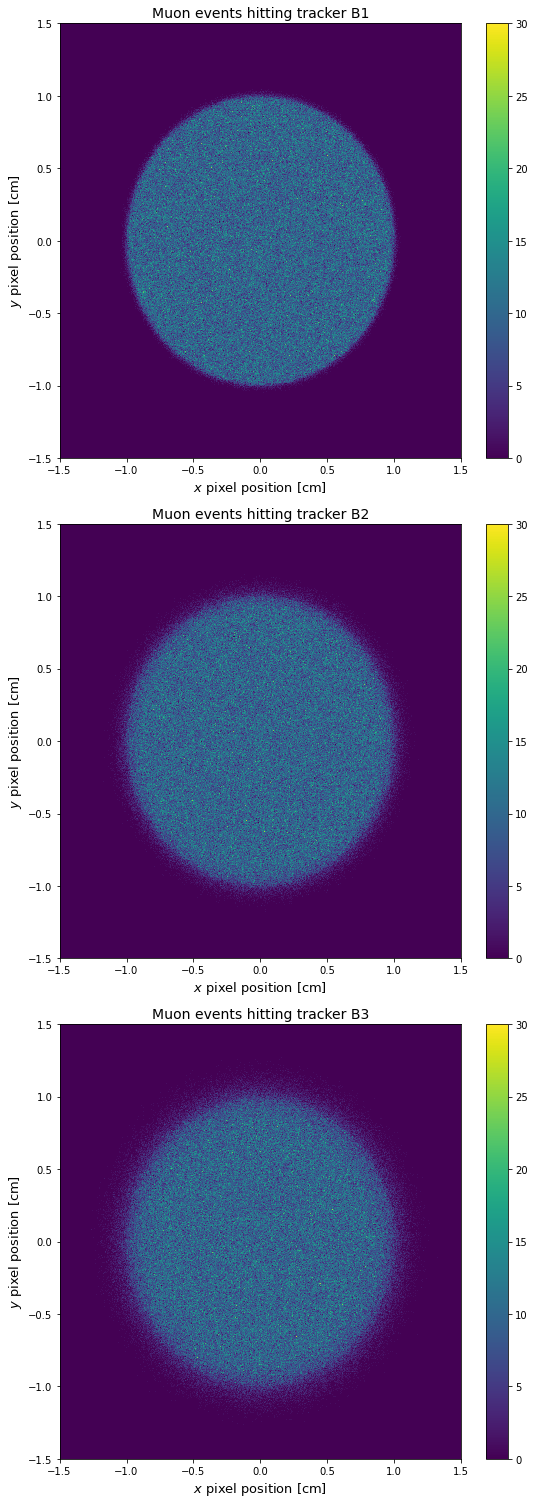

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(8,21))
hh1 = ax1.hist2d(pd.concat([100*datadet["x1B1"], 100*datadet["x1B2"]]), pd.concat([100*datadet["y1B1"], 100*datadet["y1B2"]]), range=[[-1.5, 1.5],[-1.5, 1.5]], bins=600, vmin=0, vmax=30, cmap = 'viridis')
hh2 = ax2.hist2d(pd.concat([100*datadet["x2B1"], 100*datadet["x2B2"]]), pd.concat([100*datadet["y2B1"], 100*datadet["y2B2"]]), range=[[-1.5, 1.5],[-1.5, 1.5]], bins=600, vmin=0, vmax=30, cmap = 'viridis')
hh3 = ax3.hist2d(pd.concat([100*datadet["x3B1"], 100*datadet["x3B2"]]), pd.concat([100*datadet["y3B1"], 100*datadet["y3B2"]]), range=[[-1.5, 1.5],[-1.5, 1.5]], bins=600, vmin=0, vmax=30, cmap = 'viridis')

fig.colorbar(hh1[3], ax=ax1)
fig.colorbar(hh2[3], ax=ax2)
fig.colorbar(hh3[3], ax=ax3)
ax1.set_title("Muon events hitting tracker B1",fontsize = 14)
ax1.set_xlabel("$x$ pixel position [cm]",fontsize = 13)
ax1.set_ylabel("$y$ pixel position [cm]",fontsize = 13)
ax2.set_title("Muon events hitting tracker B2",fontsize = 14)
ax2.set_xlabel("$x$ pixel position [cm]",fontsize = 13)
ax2.set_ylabel("$y$ pixel position [cm]",fontsize = 13)
ax3.set_title("Muon events hitting tracker B3",fontsize = 14)
ax3.set_xlabel("$x$ pixel position [cm]",fontsize = 13)
ax3.set_ylabel("$y$ pixel position [cm]",fontsize = 13)

fig.tight_layout()
plt.show()

In [24]:
print("Maximum number of muon 1 hitting a single pixel in tracker B1: " + str(datadet.groupby(["x1B1","y1B1"])["count"].sum().max()))
print("Maximum number of muon 2 hitting a single pixel in tracker B1: " + str(datadet.groupby(["x1B2","y1B2"])["count"].sum().max()))
print("Maximum number of muon 1 hitting a single pixel in tracker B2: " + str(datadet.groupby(["x2B1","y2B1"])["count"].sum().max()))
print("Maximum number of muon 2 hitting a single pixel in tracker B2: " + str(datadet.groupby(["x2B2","y2B2"])["count"].sum().max()))
print("Maximum number of muon 1 hitting a single pixel in tracker B3: " + str(datadet.groupby(["x3B1","y3B1"])["count"].sum().max()))
print("Maximum number of muon 2 hitting a single pixel in tracker B3: " + str(datadet.groupby(["x3B2","y3B2"])["count"].sum().max()))

print("Maximum number of muons hitting a single pixel in tracker CP1: " + str(datadet.groupby(["x1C1","y1C1"])["count"].sum().max()))
print("Maximum number of muons hitting a single pixel in tracker CN1: " + str(datadet.groupby(["x1C2","y1C2"])["count"].sum().max()))
print("Maximum number of muons hitting a single pixel in tracker CP2: " + str(datadet.groupby(["x2C1","y2C1"])["count"].sum().max()))
print("Maximum number of muons hitting a single pixel in tracker CN2: " + str(datadet.groupby(["x2C2","y2C2"])["count"].sum().max()))
print("Maximum number of muons hitting a single pixel in tracker CP3: " + str(datadet.groupby(["x3C1","y3C1"])["count"].sum().max()))
print("Maximum number of muons hitting a single pixel in tracker CN3: " + str(datadet.groupby(["x3C2","y3C2"])["count"].sum().max()))

# I make an array that stores the number of hits in each pixel
def hitgrid(nxpixel, nypixel, xlab, ylab, res):
    dataxy = datadet.loc[:,[xlab, ylab, "count"]]
    dataxy[xlab] = (np.around((dataxy[xlab]-0.5*res)/res, 6) + nxpixel/2).astype(int)
    dataxy[ylab] = (np.around((dataxy[ylab]-0.5*res)/res, 6) + nypixel/2).astype(int)
    xy = dataxy.groupby([xlab, ylab])["count"].sum()

    hits = np.zeros([nxpixel, nypixel])
    for i in range(len(xy.index)):
        hits[xy.index[i][0], xy.index[i][1]] = xy.values[i]
    return hits

# Storing
A1grid = hitgrid(600, 600, "x1A", "y1A", resA)
A2grid = hitgrid(600, 600, "x2A", "y2A", resA)
A3grid = hitgrid(600, 600, "x3A", "y3A", resA)

B1grid1 = hitgrid(600, 600, "x1B1", "y1B1", resB)
B2grid1 = hitgrid(600, 600, "x2B1", "y2B1", resB)
B3grid1 = hitgrid(600, 600, "x3B1", "y3B1", resB)
B1grid2 = hitgrid(600, 600, "x1B2", "y1B2", resB)
B2grid2 = hitgrid(600, 600, "x2B2", "y2B2", resB)
B3grid2 = hitgrid(600, 600, "x3B2", "y3B2", resB)

B1grid = B1grid1 + B1grid2
B2grid = B2grid1 + B2grid2
B3grid = B3grid1 + B3grid2

C1grid1 = hitgrid(650, 250, "x1C1", "y1C1", resC)
C2grid1 = hitgrid(850, 250, "x2C1", "y2C1", resC)
C3grid1 = hitgrid(950, 350, "x3C1", "y3C1", resC)
C1grid2 = hitgrid(650, 250, "x1C2", "y1C2", resC)
C2grid2 = hitgrid(850, 250, "x2C2", "y2C2", resC)
C3grid2 = hitgrid(950, 350, "x3C2", "y3C2", resC)

Maximum number of muon 1 hitting a single pixel in tracker B1: 17
Maximum number of muon 2 hitting a single pixel in tracker B1: 19
Maximum number of muon 1 hitting a single pixel in tracker B2: 21
Maximum number of muon 2 hitting a single pixel in tracker B2: 17
Maximum number of muon 1 hitting a single pixel in tracker B3: 17
Maximum number of muon 2 hitting a single pixel in tracker B3: 16
Maximum number of muons hitting a single pixel in tracker CP1: 63
Maximum number of muons hitting a single pixel in tracker CN1: 66
Maximum number of muons hitting a single pixel in tracker CP2: 48
Maximum number of muons hitting a single pixel in tracker CN2: 50
Maximum number of muons hitting a single pixel in tracker CP3: 39
Maximum number of muons hitting a single pixel in tracker CN3: 41


It must be pointed out that it is not possible to distinguish positive from negative muons before the magnet only using the hit information in the B trackers. Therefore in the previous cell the charge of the muon has not been explicited, referring to them with their indices even if this information is known here because the hits were reconstructed from the known tracks and not vice versa.

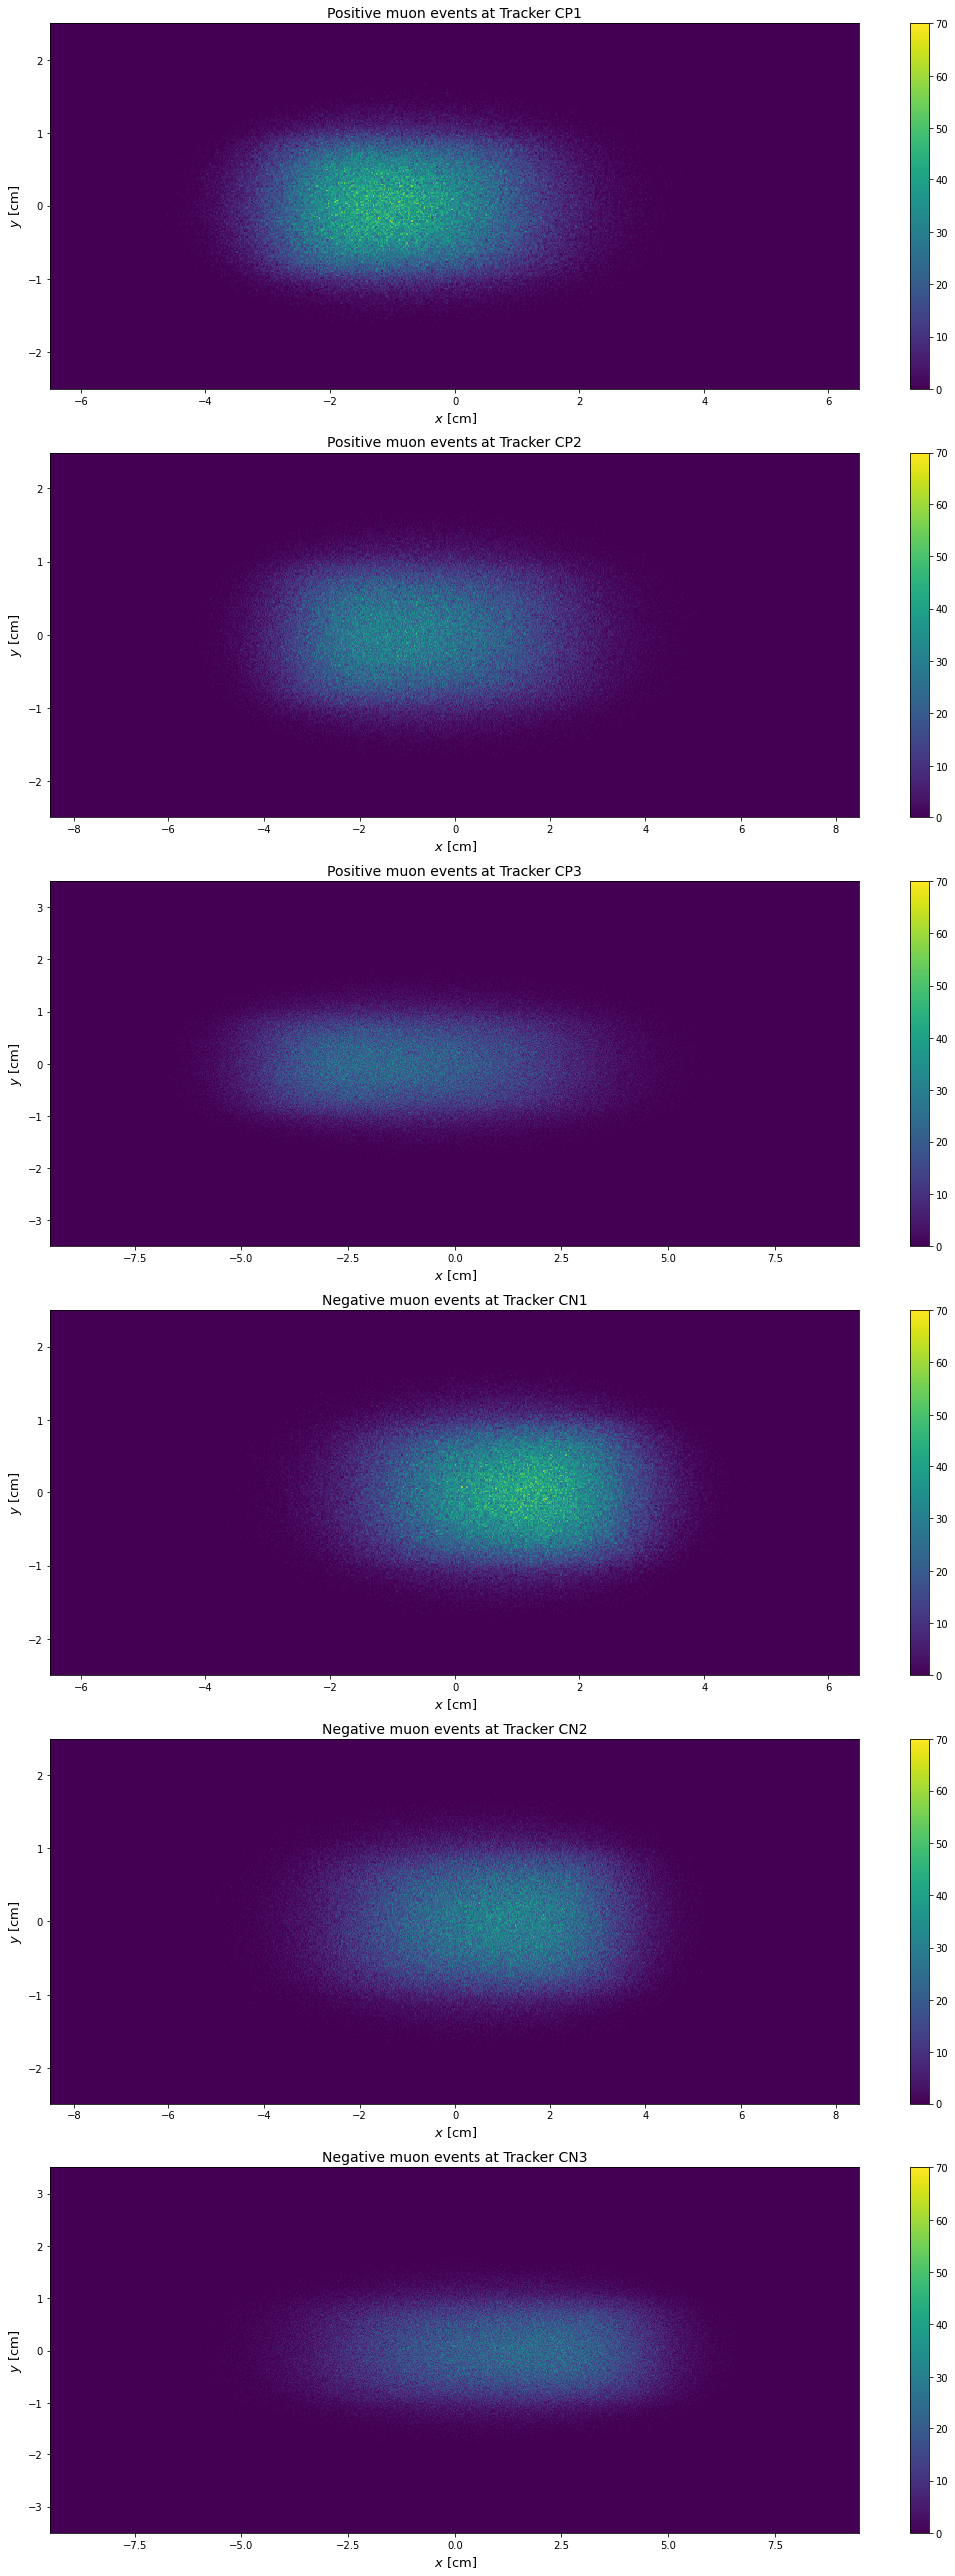

In [25]:
fig, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(nrows=6, ncols=1, figsize=(15,36))
hh1 = ax1.hist2d(100*datadet["x1C1"], 100*datadet["y1C1"], bins=[650,250], range=[[-6.5, 6.5],[-2.5, 2.5]], vmin=0, vmax=70)
hh4 = ax4.hist2d(100*datadet["x1C2"], 100*datadet["y2C2"], bins=[650,250], range=[[-6.5, 6.5],[-2.5, 2.5]], vmin=0, vmax=70)
hh2 = ax2.hist2d(100*datadet["x2C1"], 100*datadet["y2C1"], bins=[850,250], range=[[-8.5, 8.5],[-2.5, 2.5]], vmin=0, vmax=70)
hh5 = ax5.hist2d(100*datadet["x2C2"], 100*datadet["y2C2"], bins=[850,250], range=[[-8.5, 8.5],[-2.5, 2.5]], vmin=0, vmax=70)
hh3 = ax3.hist2d(100*datadet["x3C1"], 100*datadet["y3C1"], bins=[950,350], range=[[-9.5, 9.5],[-3.5, 3.5]], vmin=0, vmax=70)
hh6 = ax6.hist2d(100*datadet["x3C2"], 100*datadet["y3C2"], bins=[950,350], range=[[-9.5, 9.5],[-3.5, 3.5]], vmin=0, vmax=70)

fig.colorbar(hh1[3], ax=ax1)
fig.colorbar(hh2[3], ax=ax2)
fig.colorbar(hh3[3], ax=ax3)
fig.colorbar(hh4[3], ax=ax4)
fig.colorbar(hh5[3], ax=ax5)
fig.colorbar(hh6[3], ax=ax6)
ax1.set_title("Positive muon events at Tracker CP1",fontsize = 14)
ax1.set_xlabel("$x$ [cm]",fontsize = 13)
ax1.set_ylabel("$y$ [cm]",fontsize = 13)
ax4.set_title("Negative muon events at Tracker CN1",fontsize = 14)
ax4.set_xlabel("$x$ [cm]",fontsize = 13)
ax4.set_ylabel("$y$ [cm]",fontsize = 13)
ax2.set_title("Positive muon events at Tracker CP2",fontsize = 14)
ax2.set_xlabel("$x$ [cm]",fontsize = 13)
ax2.set_ylabel("$y$ [cm]",fontsize = 13)
ax5.set_title("Negative muon events at Tracker CN2",fontsize = 14)
ax5.set_xlabel("$x$ [cm]",fontsize = 13)
ax5.set_ylabel("$y$ [cm]",fontsize = 13)
ax3.set_title("Positive muon events at Tracker CP3",fontsize = 14)
ax3.set_xlabel("$x$ [cm]",fontsize = 13)
ax3.set_ylabel("$y$ [cm]",fontsize = 13)
ax6.set_title("Negative muon events at Tracker CN3",fontsize = 14)
ax6.set_xlabel("$x$ [cm]",fontsize = 13)
ax6.set_ylabel("$y$ [cm]",fontsize = 13)

fig.tight_layout()
plt.show()

# Noise generation

In order to generate noise hits, each pixel of all trackers are added a number of hits generated from a poissonian distribution having mean = 1.

In [26]:
# Generates a number from a poissonian distribution with mean=1 for each pixel and adds the number to the number of hits in the pixel
def noisegrid(nxpixel, nypixel):
    bkg = np.random.poisson(1, [nxpixel, nypixel])
    return bkg

A1grid = A1grid + noisegrid(600, 600)
A2grid = A2grid + noisegrid(600, 600)
A3grid = A3grid + noisegrid(600, 600)
B1grid = B1grid + noisegrid(600, 600)
B2grid = B2grid + noisegrid(600, 600)
B3grid = B3grid + noisegrid(600, 600)
C1grid1 = C1grid1 + noisegrid(650, 250)
C1grid2 = C1grid2 + noisegrid(650, 250)
C2grid1 = C2grid1 + noisegrid(850, 250)
C2grid2 = C2grid2 + noisegrid(850, 250)
C3grid1 = C3grid1 + noisegrid(950, 350)
C3grid2 = C3grid2 + noisegrid(950, 350)

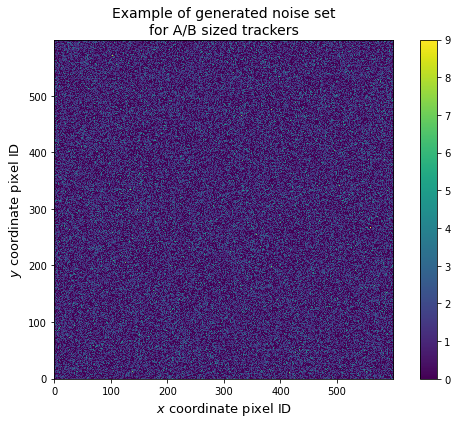

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
hh = ax.imshow(np.transpose(noisegrid(600,600)), interpolation="nearest")

ax.set_title("Example of generated noise set\nfor A/B sized trackers", fontsize=14)
ax.set_xlabel("$x$ coordinate pixel ID", fontsize=13)
ax.set_ylabel("$y$ coordinate pixel ID", fontsize=13)
ax.invert_yaxis()
fig.colorbar(hh, ax=ax)
fig.tight_layout()

plt.show()

The following plots show the number of hits in some of the trackers after the noise has been added. The plots shown this way do not look much different from the ones in the previous section, but it has a huge impact in the reconstruction of the tracks from an analysis point of view, since we do not have any prior information on the hits to be associated to reconstruct a track.

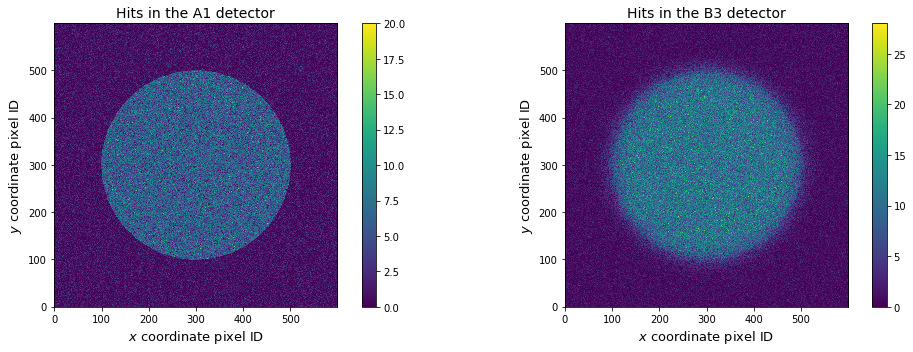

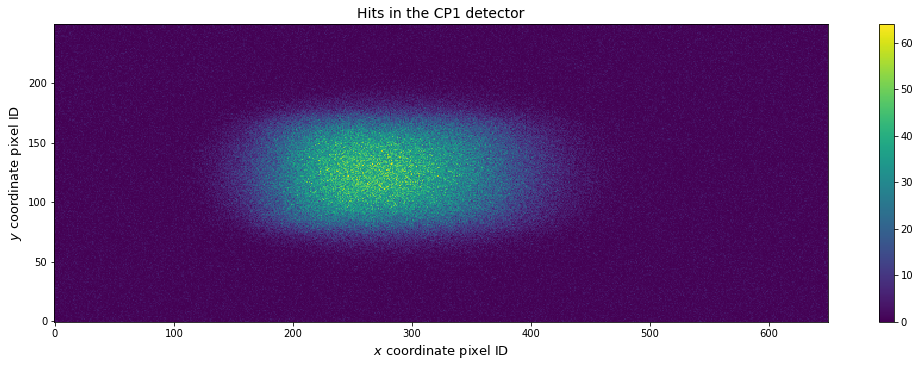

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14.5,5))
hh1 = ax1.imshow(np.transpose(A1grid), interpolation="nearest")
hh2 = ax2.imshow(np.transpose(B3grid), interpolation="nearest")

ax1.set_title("Hits in the A1 detector", fontsize=14)
ax1.set_xlabel("$x$ coordinate pixel ID", fontsize=13) # The conversion coordinate-ID is given in the hitgrid function above
ax1.set_ylabel("$y$ coordinate pixel ID", fontsize=13)
ax1.invert_yaxis()
fig.colorbar(hh1, ax=ax1)

ax2.set_title("Hits in the B3 detector", fontsize=14)
ax2.set_xlabel("$x$ coordinate pixel ID", fontsize=13) # The conversion coordinate-ID is given in the hitgrid function above
ax2.set_ylabel("$y$ coordinate pixel ID", fontsize=13)
ax2.invert_yaxis()
fig.colorbar(hh2, ax=ax2)
fig.tight_layout()

fig2, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
hh3 = ax3.imshow(np.transpose(C1grid1), interpolation="nearest")

ax3.set_title("Hits in the CP1 detector", fontsize=14)
ax3.set_xlabel("$x$ coordinate pixel ID", fontsize=13)
ax3.set_ylabel("$y$ coordinate pixel ID", fontsize=13)
ax3.invert_yaxis()
fig2.colorbar(hh3, ax=ax3)
fig2.tight_layout()

plt.show()

# Track reconstruction

Once the muons interacted with each tracker generating a hit signal in the silicon pixels, it's possible to start the track reconstruction of the events.
This is performed by applying linear regressions among the hits in each tracker group, estimating the trajectory of the incident particles.

In [29]:
# Discretized coordinates of the positron hits in the A trackers for each event
a1 = [datadet["x1A"].values, datadet["y1A"].values, np.full(len(datadet["x1A"]), -3)]
a2 = [datadet["x2A"].values, datadet["y2A"].values, np.full(len(datadet["x2A"]), -2)]
a3 = [datadet["x3A"].values, datadet["y3A"].values, np.full(len(datadet["x3A"]), -1)]

# Discretized coordinates of the muon 1 hits in the B trackers for each event
b11 = [datadet["x1B1"].values, datadet["y1B1"].values, np.full(len(datadet["x1B1"]), 0.5)]
b21 = [datadet["x2B1"].values, datadet["y2B1"].values, np.full(len(datadet["x2B1"]), 1.5)]
b31 = [datadet["x3B1"].values, datadet["y3B1"].values, np.full(len(datadet["x3B1"]), 2.5)]

# Discretized coordinates of the muon 2 hits in the B trackers for each event
b12 = [datadet["x1B2"].values, datadet["y1B2"].values, np.full(len(datadet["x1B2"]), 0.5)]
b22 = [datadet["x2B2"].values, datadet["y2B2"].values, np.full(len(datadet["x2B2"]), 1.5)]
b32 = [datadet["x3B2"].values, datadet["y3B2"].values, np.full(len(datadet["x3B2"]), 2.5)]

# Discretized coordinates of the positive muon hits in the B trackers for each event
c11 = [datadet["x1C1"].values + 0.125, datadet["y1C1"].values, np.full(len(datadet["x1C1"]), 6.5)]
c21 = [datadet["x2C1"].values + 0.17, datadet["y2C1"].values, np.full(len(datadet["x2C1"]), 7.5)]
c31 = [datadet["x3C1"].values + 0.22, datadet["y3C1"].values, np.full(len(datadet["x3C1"]), 8.5)]

# Discretized coordinates of the negative muon hits in the B trackers for each event
c12 = [datadet["x1C2"].values - 0.125, datadet["y1C2"].values, np.full(len(datadet["x1C2"]), 6.5)]
c22 = [datadet["x2C2"].values - 0.17, datadet["y2C2"].values, np.full(len(datadet["x2C2"]), 7.5)]
c32 = [datadet["x3C2"].values - 0.22, datadet["y3C2"].values, np.full(len(datadet["x3C2"]), 8.5)]

In [30]:
# spatial resolution for silicon pixels
err50 = 50*10**(-6)/np.sqrt(12)
err200 = 200*10**(-6)/np.sqrt(12)

def linearfit(x,z,error): # fit function in the plane xz, x=a+bz
    '''linear fit between i-th element in tracker 1 and i-th element in tracker 2'''
    n = len(x)
    
    Delta = n * np.sum(z**2) - np.sum(z)**2
    a_i = (np.sum(z**2) - z * np.sum(z)) / Delta
    b_i = (n * z - np.sum(z)) / Delta

    a_x = np.sum(a_i * x)
    b_x = np.sum(b_i * x)

        # errors
    sigmaa_x = error * np.sqrt(np.sum(z**2) / Delta)
    sigmab_x = error * np.sqrt(n / Delta)

    return a_x, b_x, sigmaa_x, sigmab_x

def linearfity(y,z,error): # fit function in the plane yz, y=a+bz

    n = len(y)
    Delta = n * np.sum(z**2) - np.sum(z)**2
    a_i = (np.sum(z**2) - z * np.sum(z)) / Delta
    b_i = (n * z - np.sum(z)) / Delta

    # zy plane linear fit 
    a_y = np.sum(a_i * y) 
    b_y = np.sum(b_i * y)

    # errors
    sigmaa_y = error * np.sqrt(np.sum(z**2) / Delta)
    sigmab_y = error * np.sqrt(n / Delta)

    return a_y, b_y, sigmaa_y, sigmab_y   

The following plots show the reconstructed particle tracks in the various tracker sections, projected in the x-z and y-z planes.

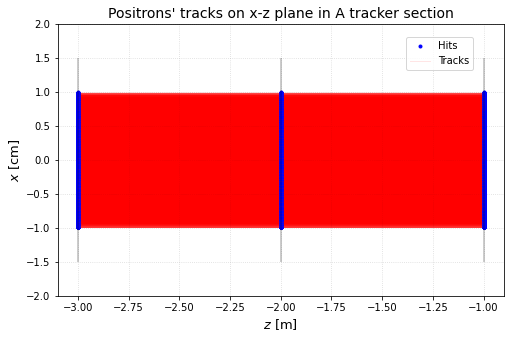

In [31]:
NA = 10000
a_xA = np.zeros(NA)
b_xA = np.zeros(NA)
sigma_axA = np.zeros(NA)
sigma_bxA = np.zeros(NA)

a_yA = np.zeros(NA)
b_yA = np.zeros(NA)
sigma_ayA = np.zeros(NA)
sigma_byA = np.zeros(NA)

xA = np.array([a1[0],a2[0],a3[0]])
yA = np.array([a1[1],a2[1],a3[1]])
zA = np.array([a1[2],a2[2],a3[2]])

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
for i in range(NA):
    x_data = np.array([a1[0][i],a2[0][i],a3[0][i]])
    z_data = np.array([a1[2][i],a2[2][i],a3[2][i]])
  
    a_xA[i], b_xA[i], sigma_axA[i], sigma_bxA[i] = linearfit(x_data, z_data, err50)
    
    ax1.plot(z_data,  x_data*100, '.', c = 'b')
    ax1.plot(z_data, (a_xA[i]+b_xA[i]*z_data)*100, c = 'r', linewidth=1, alpha=0.1)

ax1.set_ylabel("$x$ [cm]",fontsize = 13)
ax1.set_xlabel("$z$ [m]",fontsize = 13)
ax1.set_title("Positrons' tracks on x-z plane in A tracker section", fontsize = 14)
ax1.set_ylim([-2, 2])
    
trackerA = [[(-3, -1.5), (-3, 1.5)], [(-2, -1.5), (-2, 1.5)], [(-1, -1.5), (-1, 1.5)]]
lc = mc.LineCollection(trackerA, colors="k", linewidths=2, alpha=0.2)
ax1.add_collection(lc)
ax1.legend(["Hits", "Tracks"], loc=(0.78, 0.83))

plt.grid(alpha=0.5, linestyle=":")
plt.show()

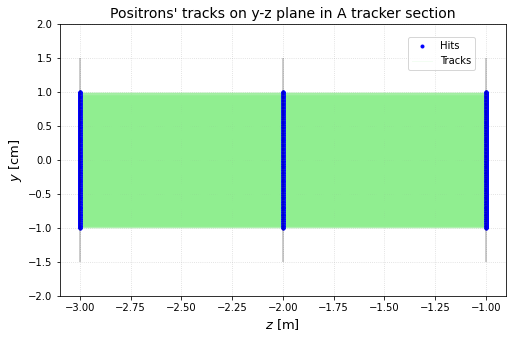

In [32]:
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
for i in range(NA):
    y_data = np.array([a1[1][i],a2[1][i],a3[1][i]])
    z_data = np.array([a1[2][i],a2[2][i],a3[2][i]])
  
    a_yA[i], b_yA[i], sigma_ayA[i], sigma_byA[i]  = linearfity(y_data, z_data, err50)
    
    ax2.plot(z_data,  y_data*100, '.',c = 'b')
    ax2.plot(z_data, (a_yA[i]+b_yA[i]*z_data)*100,c = 'Lightgreen', linewidth=1, alpha=0.1)

ax2.set_ylabel("$y$ [cm]",fontsize = 13)
ax2.set_xlabel("$z$ [m]",fontsize = 13)
ax2.set_title("Positrons' tracks on y-z plane in A tracker section", fontsize = 14)
ax2.set_ylim([-2, 2])

trackerA = [[(-3, -1.5), (-3, 1.5)], [(-2, -1.5), (-2, 1.5)], [(-1, -1.5), (-1, 1.5)]]
lc = mc.LineCollection(trackerA, colors="k", linewidths=2, alpha=0.2)
ax2.add_collection(lc)
ax2.legend(["Hits", "Tracks"], loc=(0.78, 0.83))

plt.grid(alpha=0.5, linestyle=":")
plt.show()

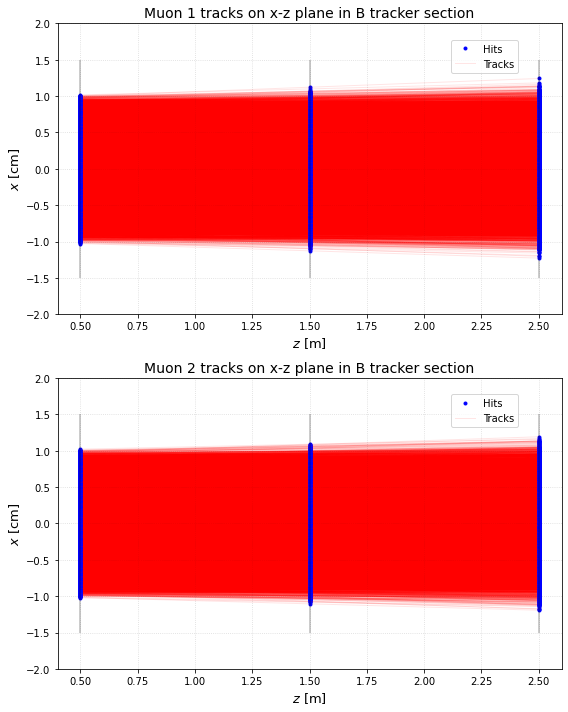

In [33]:
NB1 = 10000
a_xB1 = np.zeros(NB1)
b_xB1 = np.zeros(NB1)
sigma_axB1 = np.zeros(NB1)
sigma_bxB1 = np.zeros(NB1)

a_yBC1 = np.zeros(NB1)
b_yBC1 = np.zeros(NB1)
sigma_ayBC1 = np.zeros(NB1)
sigma_byBC1 = np.zeros(NB1)

xB1 = np.array([b11[0],b21[0],b31[0]])
yB1 = np.array([b11[1],b21[1],b31[1]])
zB1 = np.array([b11[2],b21[2],b31[2]])

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8,10))
for i in range(NB1):
    x_data = np.array([b11[0][i],b21[0][i],b31[0][i]])
    z_data = np.array([b11[2][i],b21[2][i],b31[2][i]])
  
    a_xB1[i], b_xB1[i], sigma_axB1[i], sigma_bxB1[i] = linearfit(x_data, z_data, err50)
    
    ax1.plot(z_data,  x_data*100, '.', c = 'b')
    ax1.plot(z_data, (a_xB1[i]+b_xB1[i]*z_data)*100, c = 'r', linewidth=1, alpha=0.1)
ax1.set_ylabel("$x$ [cm]",fontsize = 13)
ax1.set_xlabel("$z$ [m]",fontsize = 13)
ax1.set_title("Muon 1 tracks on x-z plane in B tracker section", fontsize = 14)
ax1.set_ylim([-2, 2])

trackerB = [[(0.5, -1.5), (0.5, 1.5)], [(1.5, -1.5), (1.5, 1.5)], [(2.5, -1.5), (2.5, 1.5)]]
lc = mc.LineCollection(trackerB, colors="k", linewidths=2, alpha=0.2)
ax1.add_collection(lc)
ax1.legend(["Hits", "Tracks"], loc=(0.78, 0.83))

ax1.grid(alpha=0.5, linestyle=":")


NB2 = 10000
a_xB2 = np.zeros(NB2)
b_xB2 = np.zeros(NB2)
sigma_axB2 = np.zeros(NB2)
sigma_bxB2 = np.zeros(NB2)

a_yBC2 = np.zeros(NB2)
b_yBC2 = np.zeros(NB2)
sigma_ayBC2 = np.zeros(NB2)
sigma_byBC2 = np.zeros(NB2)

xB2 = np.array([b12[0],b22[0],b32[0]])
yB2 = np.array([b12[1],b22[1],b32[1]])
zB2 = np.array([b12[2],b22[2],b32[2]])

for i in range(NB2):
    x_data = np.array([b12[0][i],b22[0][i],b32[0][i]])
    z_data = np.array([b12[2][i],b22[2][i],b32[2][i]])
  
    a_xB2[i], b_xB2[i], sigma_axB2[i], sigma_bxB2[i] = linearfit(x_data, z_data, err50)
    
    ax2.plot(z_data,  x_data*100, '.', c = 'b')
    ax2.plot(z_data, (a_xB2[i]+b_xB2[i]*z_data)*100, c = 'r', linewidth=1, alpha=0.1)
ax2.set_ylabel("$x$ [cm]",fontsize = 13)
ax2.set_xlabel("$z$ [m]",fontsize = 13)
ax2.set_title("Muon 2 tracks on x-z plane in B tracker section", fontsize = 14)
ax2.set_ylim([-2, 2])

lc2 = mc.LineCollection(trackerB, colors="k", linewidths=2, alpha=0.2)
ax2.add_collection(lc2)
ax2.legend(["Hits", "Tracks"], loc=(0.78, 0.83))

ax2.grid(alpha=0.5, linestyle=":")

fig.tight_layout()
plt.show()

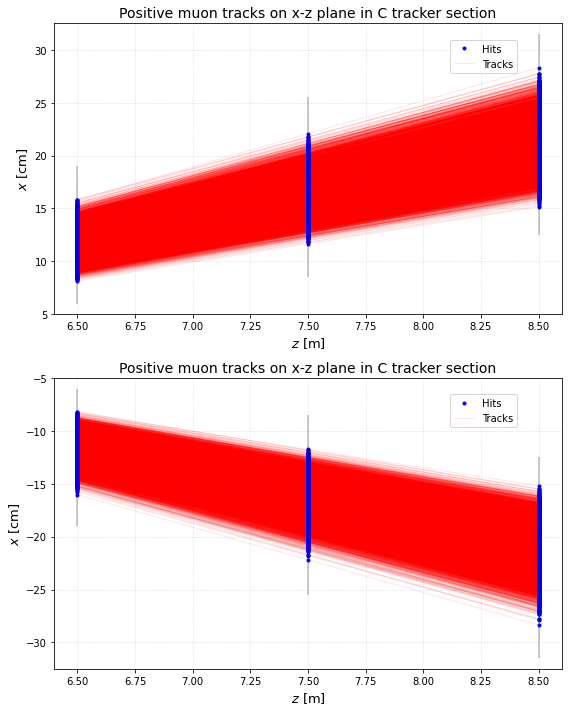

In [34]:
NC1 = 10000
a_xC1 = np.zeros(NC1)
b_xC1 = np.zeros(NC1)
sigma_axC1 = np.zeros(NC1)
sigma_bxC1 = np.zeros(NC1)

xC1 = np.array([c11[0],c21[0],c31[0]])
yC1 = np.array([c11[1],c21[1],c31[1]])
zC1 = np.array([c11[2],c21[2],c31[2]])

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8,10))
for i in range(NC1):
    x_data = np.array([c11[0][i],c21[0][i],c31[0][i]])
    z_data = np.array([c11[2][i],c21[2][i],c31[2][i]])
  
    a_xC1[i], b_xC1[i], sigma_axC1[i], sigma_bxC1[i] = linearfit(x_data, z_data, err200)

    ax1.plot(z_data,  x_data*100, '.', c = 'b')
    ax1.plot(z_data, (a_xC1[i]+b_xC1[i]*z_data)*100, c = 'r', linewidth=1, alpha=0.1)
ax1.set_ylabel("$x$ [cm]",fontsize = 13)
ax1.set_xlabel("$z$ [m]",fontsize = 13)
ax1.set_title("Positive muon tracks on x-z plane in C tracker section", fontsize = 14)
ax1.set_ylim([5, 32.5])

trackerC1 = [[(6.5, 6), (6.5, 19)], [(7.5, 8.5), (7.5, 25.5)], [(8.5, 12.5), (8.5, 31.5)]]
lc = mc.LineCollection(trackerC1, colors="k", linewidths=2, alpha=0.2)
ax1.add_collection(lc)
ax1.legend(["Hits", "Tracks"], loc=(0.78, 0.83))

ax1.grid(alpha=0.5, linestyle=":")

NC2 = 10000
a_xC2 = np.zeros(NC2)
b_xC2 = np.zeros(NC2)
sigma_axC2 = np.zeros(NC2)
sigma_bxC2 = np.zeros(NC2)

xC2 = np.array([c12[0],c22[0],c32[0]])
yC2 = np.array([c12[1],c22[1],c32[1]])
zC2 = np.array([c12[2],c22[2],c32[2]])

for i in range(NC2):
    x_data = np.array([c12[0][i],c22[0][i],c32[0][i]])
    z_data = np.array([c12[2][i],c22[2][i],c32[2][i]])
  
    a_xC2[i], b_xC2[i], sigma_axC2[i], sigma_bxC2[i] = linearfit(x_data, z_data, err200)

    ax2.plot(z_data,  x_data*100, '.', c = 'b')
    ax2.plot(z_data, (a_xC2[i]+b_xC2[i]*z_data)*100, c = 'r', linewidth=1, alpha=0.1)
ax2.set_ylabel("$x$ [cm]",fontsize = 13)
ax2.set_xlabel("$z$ [m]",fontsize = 13)
ax2.set_title("Positive muon tracks on x-z plane in C tracker section", fontsize = 14)
ax2.set_ylim([-32.5, -5])

trackerC2 = [[(6.5, -6), (6.5, -19)], [(7.5, -8.5), (7.5, -25.5)], [(8.5, -12.5), (8.5, -31.5)]]
lc2 = mc.LineCollection(trackerC2, colors="k", linewidths=2, alpha=0.2)
ax2.add_collection(lc2)
ax2.legend(["Hits", "Tracks"], loc=(0.78, 0.83))

ax2.grid(alpha=0.5, linestyle=":")

fig.tight_layout()

plt.show()

Analysing the x-z components of the muons in the C tracker section, the effects of the magnetic field are clear and the two beams are visibly distinct. Moreover it can be seen that the further the beam propagates away from the magnet, the transversal distribution of the particles spreads out faster compared to before the magnet.

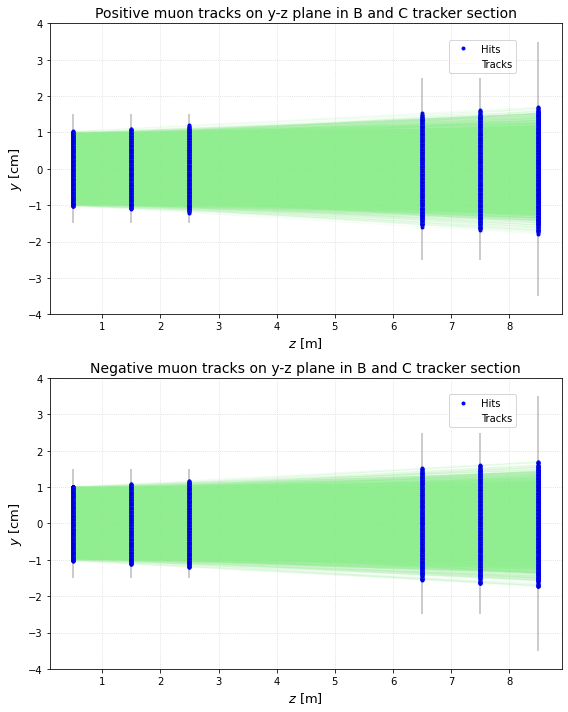

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8,10))
for i in range(NC1):
    y_data = np.array([b11[1][i],b21[1][i],b31[1][i],c11[1][i],c21[1][i],c31[1][i]])
    z_data = np.array([b11[2][i],b21[2][i],b31[2][i],c11[2][i],c21[2][i],c31[2][i]])
  
    a_yBC1[i], b_yBC1[i], sigma_ayBC1[i], sigma_byBC1[i]  = linearfity(y_data, z_data, err200)

    ax1.plot(z_data,  y_data*100, '.',c = 'b')
    ax1.plot(z_data, (a_yBC1[i]+b_yBC1[i]*z_data)*100, c = 'Lightgreen', linewidth=1, alpha=0.1)
ax1.set_ylabel("$y$ [cm]", fontsize = 13)
ax1.set_xlabel("$z$ [m]", fontsize = 13)
ax1.set_title("Positive muon tracks on y-z plane in B and C tracker section", fontsize = 14)
ax1.set_ylim([-4, 4])

trackerB = [[(0.5, -1.5), (0.5, 1.5)], [(1.5, -1.5), (1.5, 1.5)], [(2.5, -1.5), (2.5, 1.5)]]
trackerC1 = [[(6.5, -2.5), (6.5, 2.5)], [(7.5, -2.5), (7.5, 2.5)], [(8.5, -3.5), (8.5, 3.5)]]
lc = mc.LineCollection(trackerB+trackerC1, colors="k", linewidths=2, alpha=0.2)
ax1.add_collection(lc)
ax1.legend(["Hits", "Tracks"], loc=(0.78, 0.83))

ax1.grid(alpha=0.5, linestyle=":")


for i in range(NC2):
    
    y_data = np.array([b12[1][i],b22[1][i],b32[1][i], c12[1][i],c22[1][i],c32[1][i]])
    z_data = np.array([b12[2][i],b22[2][i],b32[2][i], c12[2][i],c22[2][i],c32[2][i]])
  
    a_yBC2[i], b_yBC2[i], sigma_ayBC2[i], sigma_byBC2[i] = linearfity(y_data, z_data, err200)

    ax2.plot(z_data,  y_data*100, '.', c = 'b')
    ax2.plot(z_data, (a_yBC2[i]+b_yBC2[i]*z_data)*100, c = 'Lightgreen', linewidth=1, alpha=0.1)
ax2.set_ylabel("$y$ [cm]",fontsize = 13)
ax2.set_xlabel("$z$ [m]",fontsize = 13)
ax2.set_title("Negative muon tracks on y-z plane in B and C tracker section", fontsize = 14)
ax2.set_ylim([-4, 4])

lc2 = mc.LineCollection(trackerB+trackerC1, colors="k", linewidths=2, alpha=0.2)
ax2.add_collection(lc2)
ax2.legend(["Hits", "Tracks"], loc=(0.78, 0.83))

ax2.grid(alpha=0.5, linestyle=":")

fig.tight_layout()
plt.show()

Analysing instead the y-z components of the muons in the C tracker section, the effects of the magnetic field are nonexistent, therefore the particles keep moving undisturbed through the magnet along the direction they had in the B section. 

It must be pointed out that in the y-z components track reconstruction shown in the last plots, muons 1 in the B sector were considered as the positive muons and the muons 2 as the negative muons, therefore the reconstruction was done associating muon 1(B section)-positive muon(C section) and muon 2(B)-negative muon(C). This can be done because the other combination of muons does not result in a good track reconstruction since the two muons have opposite $y$ component of the momentum (i.e. hits moving towards negative y coordinate in the B section are associated to hits moving towards positive y coordinate in the C section).
This association can also be shown to be right in the following steps analysing the trajectory of the particles in the x-z plane, where the magnetic field is taken into account.

At this point the main variables to reconstruct the trajectory inside the magnet and determine the magnetic field dimensions are calculated, using the parameters obtained in the linear regressions before and after the magnetic field.

In [36]:
# Entry point and exit point of the muons on the magnet, using the fit data obtained in the previous steps
xin1 = a_xB1 + 3*b_xB1
xin2 = a_xB2 + 3*b_xB2
xout1 = a_xC1 + 5*b_xC1
xout2 = a_xC2 + 5*b_xC2

yout1 = a_yBC1 + 5*b_yBC1
yout2 = a_yBC2 + 5*b_yBC2

# Calculating Larmor radius center
b_xB1ar = np.array([-1/i if i!=0 else 0 for i in b_xB1])
b_xB2ar = np.array([-1/i if i!=0 else 0 for i in b_xB2])
b_xC1ar = -1/b_xC1
b_xC2ar = -1/b_xC2

# Larmor radius center coordinates, obtained associating muons 1-2 (B section) with mu+(1), mu-(2) (C section)
# z0ij, x0ij where i stands for the entering muon, j for the outgoing muon
z011 = np.array([(xout1[i]-xin1[i]+b_xB1ar[i]*3-b_xC1ar[i]*5)/(b_xB1ar[i]-b_xC1ar[i]) if b_xB1ar[i]!=0 else 3 for i in range(len(b_xB1))])
x011 = xout1+b_xC1ar*(z011-5)
center11 = np.array([x011, z011])
z012 = np.array([(xout2[i]-xin1[i]+b_xB1ar[i]*3-b_xC2ar[i]*5)/(b_xB1ar[i]-b_xC2ar[i]) if b_xB1ar[i]!=0 else 3 for i in range(len(b_xB1))])
x012 = xout2+b_xC2ar*(z012-5)
center12 = np.array([x012, z012])

z021 = np.array([(xout1[i]-xin2[i]+b_xB2ar[i]*3-b_xC1ar[i]*5)/(b_xB2ar[i]-b_xC1ar[i]) if b_xB2ar[i]!=0 else 3 for i in range(len(b_xB2))])
x021 = xout1+b_xC1ar*(z021-5)
center21 = np.array([x021, z021])
z022 = np.array([(xout2[i]-xin2[i]+b_xB2ar[i]*3-b_xC2ar[i]*5)/(b_xB2ar[i]-b_xC2ar[i]) if b_xB2ar[i]!=0 else 3 for i in range(len(b_xB2))])
x022 = xout2+b_xC2ar*(z022-5)
center22 = np.array([x022, z022])

We can now proceed with the reconstruction of the trajectories inside the magnet and put all the sections together into a final result. 

In [37]:
# Matrix storing z coordinates of each event
zAtrack = np.array([np.linspace(-3, 0, 301) for i in range(NA)])
zBtrack = np.array([np.linspace(0, 3, 301) for i in range(NA)])
zMtrack = np.array([np.linspace(3, 5, 201) for i in range(NA)])
zCtrack = np.array([np.linspace(5, 8.5, 351) for i in range(NA)])
ztrack = np.array([np.linspace(-3, 8.5, 1151) for i in range(NA)])

# Function to obtain the x or y coordinate of a particle in free motion given z
def plotlin(z, a, b):
    #print(a.shape, b.shape, z.shape)
    amatr = np.transpose(np.tile(a, (z.shape[1],1)))
    bmatr = np.transpose(np.tile(b, (z.shape[1],1)))
    x = amatr + bmatr*z
    #print(x.shape)
    return x

# Function to obtain the x coordinate of a positive muon in the magnet given z, the entry point and the larmor radius
def plotcurvpos(z, xin, larmorcenter):
    xim = np.transpose(np.tile(xin, (z.shape[1],1)))
    lr0 = np.transpose(np.tile(larmorcenter[0], (z.shape[1],1)))
    lr1 = np.transpose(np.tile(larmorcenter[1], (z.shape[1],1)))
    r = np.sqrt((xim-lr0)**2+(3-lr1)**2)
    x = lr0 - np.sqrt(r**2 - (z - lr1)**2)
    return x

# Function to obtain the x coordinate of a negative muon in the magnet given z, the entry point and the larmor radius
def plotcurvneg(z, xin, larmorcenter):
    xim = np.transpose(np.tile(xin, (z.shape[1],1)))
    lr0 = np.transpose(np.tile(larmorcenter[0], (z.shape[1],1)))
    lr1 = np.transpose(np.tile(larmorcenter[1], (z.shape[1],1)))
    r = np.sqrt((xim-lr0)**2+(3-lr1)**2)
    x = lr0 + np.sqrt(r**2 - (z - lr1)**2)
    return x

# Calculating x coordinates of the particles along the trajectories in the various tracker sections
xAtrack = plotlin(zAtrack, a_xA, b_xA)
xBtrack1 = plotlin(zBtrack, a_xB1, b_xB1)
xBtrack2 = plotlin(zBtrack, a_xB2, b_xB2)
xCtrack1 = plotlin(zCtrack, a_xC1, b_xC1)
xCtrack2 = plotlin(zCtrack, a_xC2, b_xC2)

# Calculating y coordinates of the particles along the trajectories  in the various tracker sections
yAtrack = plotlin(zAtrack, a_yA, b_yA) # positron
ytrack = plotlin(np.concatenate([zBtrack[:,:-1], zMtrack[:,:-1], zCtrack], axis=1), a_yA, b_yA) # muon

# Calculating x coordinates of the particles along the trajectories inside the magnet
xMtrack11 = plotcurvpos(zMtrack, xin1, center11)
xMtrack12 = plotcurvneg(zMtrack, xin1, center12)
xMtrack21 = plotcurvpos(zMtrack, xin2, center21)
xMtrack22 = plotcurvneg(zMtrack, xin2, center22)

In [38]:
# Putting together every section to form a complete track
xtrack11 = np.concatenate([xAtrack[:,:-1], xBtrack1[:,:-1], xMtrack11[:,:-1], xCtrack1], axis=1)
xtrack12 = np.concatenate([xAtrack[:,:-1], xBtrack1[:,:-1], xMtrack12[:,:-1], xCtrack2], axis=1)
xtrack21 = np.concatenate([xAtrack[:,:-1], xBtrack2[:,:-1], xMtrack21[:,:-1], xCtrack1], axis=1)
xtrack22 = np.concatenate([xAtrack[:,:-1], xBtrack2[:,:-1], xMtrack22[:,:-1], xCtrack2], axis=1)

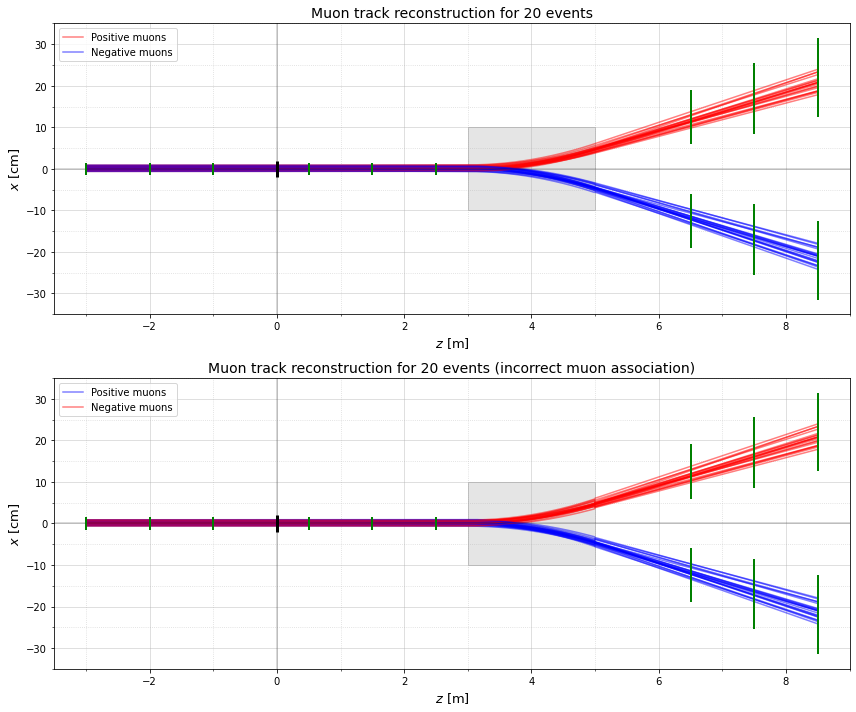

In [39]:
# Plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,10))
for i in range(20):
    ax1.plot(ztrack[i], xtrack11[i]*100, "r", alpha=0.5)
    ax1.plot(ztrack[i], xtrack22[i]*100, "b", alpha=0.5)
    ax2.plot(ztrack[i], xtrack12[i]*100, "b", alpha=0.5)
    ax2.plot(ztrack[i], xtrack21[i]*100, "r", alpha=0.5)
ax1.set_title("Muon track reconstruction for 20 events",fontsize = 14)
ax2.set_title("Muon track reconstruction for 20 events (incorrect muon association)",fontsize = 14)
ax1.set_xlim(-3.5, 9)
ax2.set_xlim(-3.5, 9)
ax1.set_ylim(-35, 35)
ax2.set_ylim(-35, 35)
ax1.set_xlabel("$z$ [m]",fontsize = 13)
ax1.set_ylabel("$x$ [cm]",fontsize = 13)
ax2.set_xlabel("$z$ [m]",fontsize = 13)
ax2.set_ylabel("$x$ [cm]",fontsize = 13)
ax1.axhline(0, color="k", alpha=0.2)
ax1.axvline(0, color="k", alpha=0.2)
ax2.axhline(0, color="k", alpha=0.2)
ax2.axvline(0, color="k", alpha=0.2)

xmajor_ticks = np.arange(-2, 10, 2)
xminor_ticks = np.arange(-3, 10, 1)
ax1.set_xticks(xmajor_ticks)
ax1.set_xticks(xminor_ticks, minor=True)
ax2.set_xticks(xmajor_ticks)
ax2.set_xticks(xminor_ticks, minor=True)
ymajor_ticks = np.arange(-30, 31, 10)
yminor_ticks = np.arange(-35, 36, 5)
ax1.set_yticks(ymajor_ticks)
ax1.set_yticks(yminor_ticks, minor=True)
ax2.set_yticks(ymajor_ticks)
ax2.set_yticks(yminor_ticks, minor=True)

fig.tight_layout()

trackerA = [[(-3, -1.5), (-3, 1.5)], [(-2, -1.5), (-2, 1.5)], [(-1, -1.5), (-1, 1.5)]]
trackerB = [[(0.5, -1.5), (0.5, 1.5)], [(1.5, -1.5), (1.5, 1.5)], [(2.5, -1.5), (2.5, 1.5)]]
trackerC1 = [[(6.5, 6), (6.5, 19)], [(7.5, 8.5), (7.5, 25.5)], [(8.5, 12.5), (8.5, 31.5)]]
trackerC2 = [[(6.5, -6), (6.5, -19)], [(7.5, -8.5), (7.5, -25.5)], [(8.5, -12.5), (8.5, -31.5)]]
target = [[(0, -2), (0, 2)]]

lc = mc.LineCollection(trackerA+trackerB+trackerC1+trackerC2, colors="g", linewidths=2)
lct = mc.LineCollection(target, colors="k", linewidths=3)
lc2 = mc.LineCollection(trackerA+trackerB+trackerC1+trackerC2, colors="g", linewidths=2)
lct2 = mc.LineCollection(target, colors="k", linewidths=3)
ax1.add_collection(lc)
ax1.add_collection(lct)
ax2.add_collection(lc2)
ax2.add_collection(lct2)

ax1.add_patch(Rectangle((3,-10), 2, 20, edgecolor = "k", facecolor = "gray", fill=True, alpha=0.2))
ax2.add_patch(Rectangle((3,-10), 2, 20, edgecolor = "k", facecolor = "gray", fill=True, alpha=0.2))

ax1.grid(which="major", alpha=0.5)
ax1.grid(which="minor", alpha=0.5, linestyle=":")
ax2.grid(which="major", alpha=0.5)
ax2.grid(which="minor", alpha=0.5, linestyle=":")

ax1.legend(["Positive muons", "Negative muons"], loc="upper left")
ax2.legend(["Positive muons", "Negative muons"], loc="upper left")
plt.show()

The first plot above shows the tracks reconstructed associating positive muons in the C tracker section with muons 1 in the B tracker section, while the second one shows the tracks obtained coupling muons 1 with negative muons. It can be seen that this second reconstruction is wrong as already discussed when the $y$ coordinates were reconstructed. In the following plots, an enlargement of the images above are shown, in proximity of the positive charged beam on the edge of the magnet.

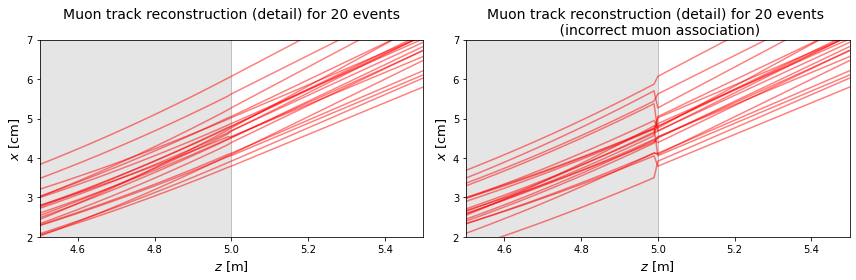

In [40]:
fig2, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
for i in range(20):
    ax3.plot(ztrack[i], xtrack11[i]*100, "r", alpha=0.5)
    ax3.plot(ztrack[i], xtrack22[i]*100, "b", alpha=0.5)
    ax4.plot(ztrack[i], xtrack12[i]*100, "b", alpha=0.5)
    ax4.plot(ztrack[i], xtrack21[i]*100, "r", alpha=0.5)
ax3.set_xlim(4.5, 5.5)
ax3.set_ylim(2, 7)
ax4.set_xlim(4.5, 5.5)
ax4.set_ylim(2, 7)
ax3.set_title("Muon track reconstruction (detail) for 20 events\n ",fontsize = 14)
ax4.set_title("Muon track reconstruction (detail) for 20 events \n (incorrect muon association)",fontsize = 14)
ax3.set_xlabel("$z$ [m]",fontsize = 13)
ax3.set_ylabel("$x$ [cm]",fontsize = 13)
ax4.set_xlabel("$z$ [m]",fontsize = 13)
ax4.set_ylabel("$x$ [cm]",fontsize = 13)

ax3.add_patch(Rectangle((3,-18), 2, 36, edgecolor = "k", facecolor = "gray", fill=True, alpha=0.2))
ax4.add_patch(Rectangle((3,-18), 2, 36, edgecolor = "k", facecolor = "gray", fill=True, alpha=0.2))
fig2.tight_layout()

plt.show()

It can be seen that the track components that have been reconstructed starting from the wrong combination do not match well on the edge of the magnet, since the trajectories of the particles before and after the magnet cannot be connected as smoothly using an arc of a circle as the corrected matched case.
Therefore it is possible to identify experimentally that the muons 1 have positive charge and muons 2 have negative charge.

# Resolution of momenta and $\sqrt{s}$

In order to calculate the momentum resolution, we start from the Larmor radius expression

$$\displaystyle{R = \frac{|p_{\perp}|}{|q|B}}$$

Inverting the expression to isolate the momentum and writing $R \approx L\theta$ for small $\theta$ values, where $L$ is the length of the magnet along the z axis and $\theta$ is the deflection angle of the muon on the x-z plane, we obtain the expression

$$\displaystyle{|p_{\perp}| = \frac{|q|BL}{\theta} \qquad |p_{\perp}[MeV/c]| = \frac{300\,B[T]\,L[m]}{\theta[radiants]} = \frac{1020}{\theta[radiants]}}$$

In the present case the only quantity in the expression having an uncertainty is the angle $\theta$.
It can be shown using some algebric calculations that the resolutions of $p_{\perp}$ and $\theta$ are the same:

$$\displaystyle{\frac{d|p_{\perp}|}{d\theta} = \frac{|q|BL}{\theta^2} = \frac{|p_{\perp}|}{\theta}}$$

$$\displaystyle{\frac{d|p_{\perp}|}{|p_{\perp}|} = \frac{d\theta}{\theta}}$$

$$\displaystyle{\frac{\sigma_{|p_{\perp}|}}{|p_{\perp}|} = \frac{\sigma_{\theta}}{\theta}}$$

Therefore the resolution on the transverse momentum can be derived directly from $\theta$ and its uncertainty.

In [41]:
# Calculating the deflection angle theta (Dtheta from Deltatheta) of the trajectory in the magnet in x-z plane
thetaB1 = np.arctan(b_xB1) # Positive muon track angle wrt z axis in B tracker section in x-z plane
thetaB2 = np.arctan(b_xB2) # Negative muon track angle wrt z axis in B tracker section in x-z plane
thetaC1 = np.arctan(b_xC1) # Positive muon track angle wrt z axis in C tracker section in x-z plane
thetaC2 = np.arctan(b_xC2) # Negative muon track angle wrt z axis in C tracker section in x-z plane

Dtheta1 = np.abs(thetaC1-thetaB1) # Deflection angle of positive muons
Dtheta2 = np.abs(thetaC2-thetaB2) # Deflection angle of negative muons
Dtheta = np.concatenate([Dtheta1, Dtheta2])

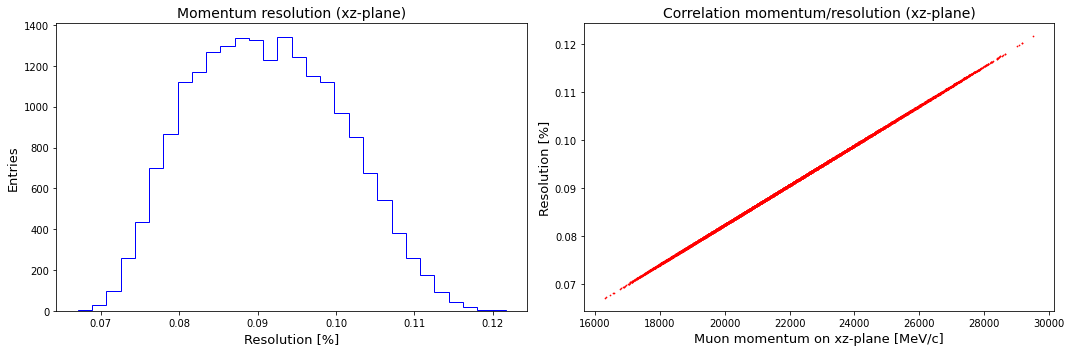

In [42]:
# Uncertainties computed through error propagation
sigma_thetaB1 = np.abs(1/(1+b_xB1**2))*sigma_bxB1
sigma_thetaC1 = np.abs(1/(1+b_xC1**2))*sigma_bxC1

sigma_thetaB2 = np.abs(1/(1+b_xB2**2))*sigma_bxB2
sigma_thetaC2 = np.abs(1/(1+b_xC2**2))*sigma_bxC2

sigma_Dtheta1 = np.sqrt(sigma_thetaB1**2+sigma_thetaC1**2)
sigma_Dtheta2 = np.sqrt(sigma_thetaB2**2+sigma_thetaC2**2)
sigma_Dtheta = np.concatenate([sigma_Dtheta1, sigma_Dtheta2])

# Momenta on x-z plane
momxz1 = 300*B*2/Dtheta1 # positive muons
momResol1 = sigma_Dtheta1/Dtheta1
momxz2 = 300*B*2/Dtheta2 # negative muons
momResol2 = sigma_Dtheta2/Dtheta2
momxz = 300*B*2/Dtheta # all muons
momResol = sigma_Dtheta/Dtheta

# Plot: resolution, correlation momentum-resolution
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.hist(100*momResol, bins=30, histtype="step", color="b")
ax1.set_title("Momentum resolution (xz-plane)",fontsize = 14)
ax1.set_xlabel("Resolution [%]",fontsize = 13)
ax1.set_ylabel("Entries",fontsize = 13)
ax2.scatter(momxz, 100*momResol, color="r", s=0.5)
ax2.set_title("Correlation momentum/resolution (xz-plane)",fontsize = 14)
ax2.set_xlabel("Muon momentum on xz-plane [MeV/c]",fontsize = 13)
ax2.set_ylabel("Resolution [%]",fontsize = 13)
fig.tight_layout()
plt.show()

The second plot displays a linear correlation between of $p_{\perp}$ and its resolution. This behaviour matches the predictions, since it's also possible to write:

$$\displaystyle{\frac{\sigma_{|p_{\perp}|}}{|p_{\perp}|} = \frac{\sigma_{\theta}}{\theta}} = \frac{|p_{\perp}|\,\sigma_{\theta}}{1020}$$

This analysis stands only for the components of the momentum perpendicular to the magnetic field. To have a resolution on the total momentum it is necessary to compute the $y$ component of the momentum.
Since this component cannot be calculated exploiting the curvature in the magnetic field, we ought to resort to other methods. In this case we exploited the correlation between the momentum components and the coordinates of the pixels hit in the B tracker section:

$$\displaystyle{\frac{p_{xB}}{\Delta x_B} = \frac{p_{yB}}{\Delta y_B}}$$

where $\Delta x_B$ and $\Delta y_B$ are the shift along the given coordinate of the particles between the interaction point and the entry point in the magnet, calculated using the parameters obtained in the linear regression to reconstruct the tracks.
Arranging the expression a bit:

$$\displaystyle{\frac{p_{xzB}\,sin(\theta _B)}{a_{xB}+b_{xB}z\,(=3)-(a_{xB}+b_{xB}z\,(=0))} = \frac{p_{yB}}{a_{yB}+b_{yB}z\,(=3)-(a_{yB}+b_{yB}z\,(=0))}}$$

$$\displaystyle{p_{yB} = \frac{b_{yB}\,p_{xzB}\,sin(\theta _B)}{b_{xzB}} \qquad (b_{xzB} = tan(\theta _B))}$$

$$\displaystyle{p_{yB} = b_{yB}\,p_{xzB}\,cos(\theta _B)}$$

The uncertainties are once again obtained by error propagation.

In [43]:
# Function to obtain the value of y momentum component with errors
def getpy(byB,momzx,thetaB,sigma_byB,sigma_momzx,sigma_thetaB):
    momy = (momzx*np.cos(thetaB))*byB
    sigma_momy = np.sqrt((np.cos(thetaB)*byB*sigma_momzx)**2+(np.cos(thetaB)*momzx*sigma_byB)**2+(np.sin(thetaB)*byB*momzx*sigma_thetaB)**2)
    return momy, sigma_momy

momy1, sigma_momy1 = getpy(b_yBC1,momxz1,thetaB1,sigma_byBC1,momxz1*momResol1,sigma_thetaB1)
momy2, sigma_momy2 = getpy(b_yBC2,momxz2,thetaB2,sigma_byBC2,momxz2*momResol2,sigma_thetaB2)

# Defining "Vectors" of momenta with x,y,z components (and error vectors)
mom1 = np.array([momxz1*np.sin(thetaB1),momy1,momxz1*np.cos(thetaB1)])
mom2 = np.array([momxz2*np.sin(thetaB2),momy2,momxz2*np.cos(thetaB2)])
sigma_mom1 = np.array([np.sqrt((momxz1*np.cos(thetaB1)*sigma_thetaB1)**2+(np.sin(thetaB1)*momxz1*momResol1)**2),sigma_momy1,np.sqrt((momxz2*np.sin(thetaB1)*sigma_thetaB1)**2+(np.cos(thetaB1)*momxz1*momResol1)**2)])
sigma_mom2 = np.array([np.sqrt((momxz2*np.cos(thetaB2)*sigma_thetaB2)**2+(np.sin(thetaB2)*momxz2*momResol2)**2),sigma_momy2,np.sqrt((momxz2*np.sin(thetaB2)*sigma_thetaB2)**2+(np.cos(thetaB2)*momxz2*momResol2)**2)])

# Magnitude of the momenta
mom1mod = np.sqrt(mom1[0]**2+mom1[1]**2+mom1[2]**2)
mom2mod = np.sqrt(mom2[0]**2+mom2[1]**2+mom2[2]**2)
mommod = np.concatenate([mom1mod, mom2mod])
sigma_mom1mod = np.sqrt(((mom1[0]*sigma_mom1[0])**2+(mom1[1]*sigma_mom1[1])**2+(mom1[2]*sigma_mom1[2])**2)/(mom1mod**2))
sigma_mom2mod = np.sqrt(((mom2[0]*sigma_mom2[0])**2+(mom2[1]*sigma_mom2[1])**2+(mom2[2]*sigma_mom2[2])**2)/(mom2mod**2))
sigma_mommod = np.concatenate([sigma_mom1mod, sigma_mom2mod])

# Resolutions of total momenta
momResoltot = sigma_mommod/mommod

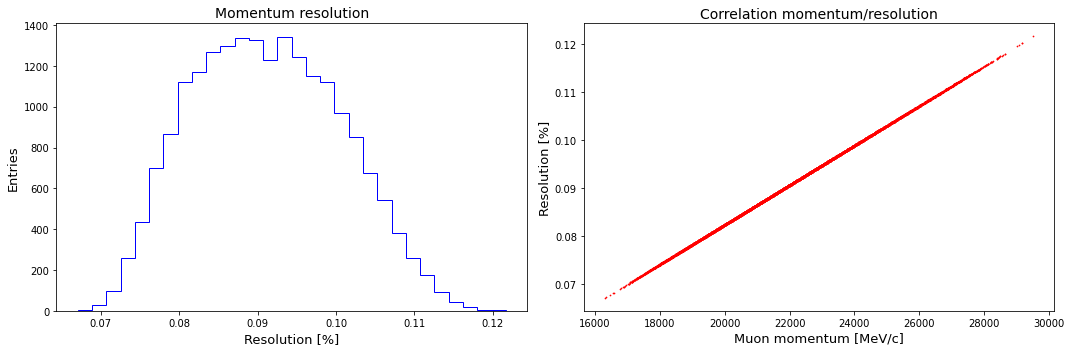

In [44]:
# Plot: resolution, correlation momentum-resolution
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.hist(100*momResoltot, bins=30, histtype="step", color="b")
ax1.set_title("Momentum resolution",fontsize = 14)
ax1.set_xlabel("Resolution [%]",fontsize = 13)
ax1.set_ylabel("Entries",fontsize = 13)
ax2.scatter(mommod, 100*momResoltot, color="r", s=0.5)
ax2.set_title("Correlation momentum/resolution",fontsize = 14)
ax2.set_xlabel("Muon momentum [MeV/c]",fontsize = 13)
ax2.set_ylabel("Resolution [%]",fontsize = 13)
fig.tight_layout()
plt.show()

Linear regression
 a = -3.654e-06 ± 2e-09
 b = 4.13380e-08 ± 1e-13 MeV/c
Covariance matrix:
 [[5.12952707e+06 2.12044203e-01]
 [2.12044203e-01 8.76547675e-09]]


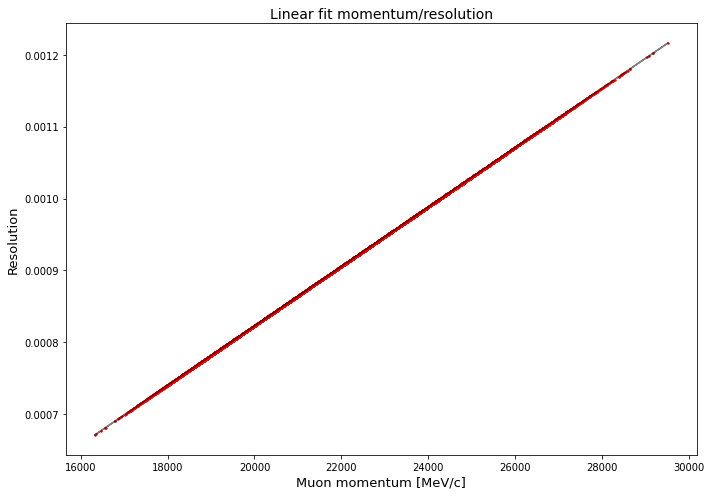

In [45]:
# Linear fit of second plot
cov = np.cov(mommod, momResoltot, ddof=2)
bcorr = cov[0,1]/cov[0,0]
acorr = np.mean(momResoltot - bcorr*mommod)

n = len(mommod)
SSR = np.sum((momResoltot - (acorr + bcorr*mommod))**2)
sigma_b = np.sqrt((SSR/(n-2)) / np.sum((mommod - np.mean(mommod))**2) )
sigma_a = np.sqrt(sigma_b**2 * np.sum(mommod**2)/n )

print("Linear regression")
print(" a = %.3e ± %.0e" % (acorr, sigma_a))
print(" b = %.5e ± %.0e MeV/c" % (bcorr, sigma_b))
print("Covariance matrix:\n", cov)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
ax.scatter(mommod, momResoltot, color="r", s=2)
ax.plot(mommod, acorr + bcorr*mommod, alpha=0.5, c="k")
ax.set_title("Linear fit momentum/resolution", fontsize = 14)
ax.set_xlabel("Muon momentum [MeV/c]", fontsize = 13)
ax.set_ylabel("Resolution",fontsize = 13)
plt.tight_layout()
plt.show()

The behaviour of the resolution of the total momentum can be considered equal to the one calculated considering only the components affected by the magnetic field since $p_y << p_z$.
The $b$ parameter obtained with the fit relates the muon momentum with its resolution.

Once obtained the information on the momenta, it's possible to determine the center of mass energy $\sqrt{s}$ and its resolution. Simply using special relativity:

$$\displaystyle{E = \sqrt{|\vec{p}|^2 + m_{\mu}^2}}$$

$$\displaystyle{\sqrt{s} = \sqrt{(E_1+E_2)^2-|\vec{p_1}+\vec{p_2}|^2}}$$

The error propagation is performed to obtain the uncertainties, using which the resolution can be computed as well.

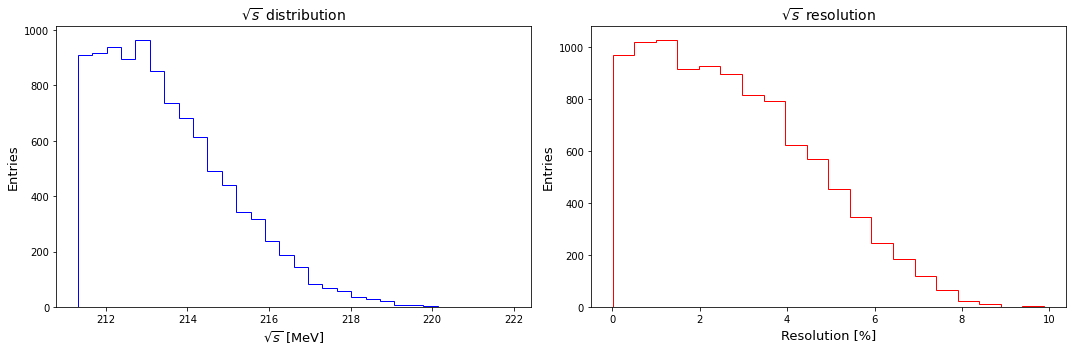

In [46]:
# Energies of muons with errors
E1 = np.sqrt(mom1[0]**2 + mom1[1]**2 + mom1[2]**2 + mmu**2)
E2 = np.sqrt(mom2[0]**2 + mom2[1]**2 + mom2[2]**2 + mmu**2)
sigma_E1 = mom1mod*sigma_mom1mod/E1
sigma_E2 = mom2mod*sigma_mom2mod/E2

# Center of mass energy with error and resolution
minv = np.sqrt((E1+E2)**2-(mom1[0]+mom2[0])**2-(mom1[1]+mom2[1])**2-(mom1[2]+mom2[2])**2)
sigma_minv = np.sqrt((1/(minv**2))*(((E1+E2)**2*((sigma_E1**2)+(sigma_E2**2)))-((mom1[0]+mom2[0])**2*((sigma_mom1[0]**2)+(sigma_mom2[0]**2)))-((mom1[1]+mom2[1])**2*((sigma_mom1[1])**2+(sigma_mom2[1])**2))-((mom1[2]+mom2[2])**2*((sigma_mom1[2])**2+(sigma_mom2[2])**2))))
minvResol = sigma_minv/minv

# Plot: CoM E distribution, resolution
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.hist(minv, histtype="step", color="b", bins=30)
ax1.set_title("$\sqrt{s}$ distribution",fontsize = 14)
ax1.set_xlabel("$\sqrt{s}$ [MeV]",fontsize = 13)
ax1.set_ylabel("Entries",fontsize = 13)
ax2.hist(100*minvResol, histtype="step", color="r", bins=20)
ax2.set_title("$\sqrt{s}$ resolution",fontsize = 14)
ax2.set_xlabel("Resolution [%]",fontsize = 13)
ax2.set_ylabel("Entries",fontsize = 13)
fig.tight_layout()
plt.show()

The $\sqrt{s}$ distribution is lower bounded because the generated events had an energy just above the $\mu^+\mu^-$ production threshold at 2m$_{\mu}\approx $ 211.4 MeV.

The correlation between $\sqrt{s}$ and its resolution are shown in the plot below.

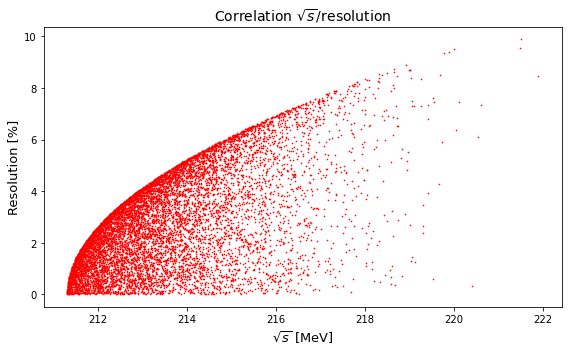

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.scatter(minv, 100*minvResol, c="r", s=0.4)
ax.set_title("Correlation $\sqrt{s}$/resolution",fontsize = 14)
ax.set_xlabel("$\sqrt{s}$ [MeV]",fontsize = 13)
ax.set_ylabel("Resolution [%]",fontsize = 13)
fig.tight_layout()
plt.show()